In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import main_single
from os.path import exists
import argparse
import matplotlib.pyplot as plt
import pandas as pd
import os, fnmatch

from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import curdoc
from bokeh.io import output_notebook


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
output_notebook()

Loading BokehJS ...

## Output comparison
I would compare two type of deep learning methods:
1. vae-rnn
2. vanila gru
3. _(maybe transformer in the future)_

and adding physical constraints:
1. pure black box methods
2. the measurement model is known
  a. soft constraints: as panelty
  b. soft constraints: as prior (for variance inference)
  c. hard constraints: inserted in decoder
3. part of dynamic model is known
  a. hard constraints: mean decoder = __nn_dec+phy+dec__
4. _(assume the model is nn+phy+gaussian)_, so we have three blocks one of which is 2d measuring the mean and variance for the normal distribution
__notice:__ VAE is chosen here because of the uncertainty in our stochastic model, while we could extract mean and variance which makes the Gaussian noise measurable


We do not care the "best" structure, the mean idea is to show the physics knowledge can improve the performance


__notice:__ improvement is possible not only in _rmse_, but also in _model size_, _vaf_

#### 30 apr 2024:

Today I write the function for plotting and compared two different activation function relu() (__this is better__) and tanh()

Continued yesterday's rnn structure, yesterday I get bad results because of no activation function

```
nohup python main_single.py --n_epoch=800 --model='AE-RNN' --h_dim=80 --z_dim=2 --dataset='toy_lgssm' --logdir='test_relu' --mpnt_wt=0 --do_test --do_train &

nohup python main_single.py --n_epoch=800 --model='AE-RNN' --h_dim=80 --z_dim=2 --dataset='toy_lgssm_5_pre' --logdir='test_relu' --mpnt_wt=0 --do_test --do_train &
```
- It is wired that toy_logssm (the random training set) has worse performance (__1.8__) than the existing dataset toy_lgssm_5_pre (__1.56__)  _hdim = 80, zdim=2_

## code implementation
- plot the estimation (y_hat) and true lable (y)
- 

In [4]:
def plot_k_nn_y(y, y_hat, rmse, panelty,h_dim,length=50,start_from=0):
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, length +1), y[start_from:start_from+length], linestyle='-',color='red',label='y_true')
    plt.plot(range(1, length +1), y_hat[start_from:start_from+length], linestyle='-',color='blue',label='y_estimate')
    lower_bound =  y[start_from:start_from+length]-y_hat[start_from:start_from+length]
    upper_bound = -y[start_from:start_from+length]+y_hat[start_from:start_from+length]
    
    # plt.plot(range(1, length +1), y[start_from:start_from+length]-y_hat[start_from:start_from+length], linestyle='-',color='red',label='residual')
    plt.fill_between(range(1, length +1), lower_bound, upper_bound, color='gray', alpha=0.3, label='Shaded Region')
    plt.xlabel('k step')
    plt.ylabel('value')
    plt.title('rmse={}, panelty={}, h_dim={}'.format(rmse,panelty,h_dim))
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()

def plot_k_nn_y_rsd(y, y_hat, rmse, panelty,h_dim,length=50,start_from=0):
    plt.figure(figsize=(12, 5))
    lower_bound =  y[start_from:start_from+length]-y_hat[start_from:start_from+length]
    upper_bound = -y[start_from:start_from+length]+y_hat[start_from:start_from+length]
    window_size = 5
    smoothed_y_res = np.convolve(lower_bound, np.ones(window_size)/window_size, mode='valid')
    # plt.plot(range(1, length +1), y[start_from:start_from+length]-y_hat[start_from:start_from+length], linestyle='-',color='red',label='residual')
    plt.fill_between(range(1, length +1), lower_bound, upper_bound, color='gray', alpha=0.3, label='Shaded Region')
    plt.plot(range(1, length +1)[window_size-1:], smoothed_y_res, label='Smoothed')
    plt.xlabel('k step')
    plt.ylabel('value')
    plt.title('rmse={}'.format(rmse,panelty,h_dim))
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()

def y_yhat_nn(pattern, rmse_path, panelty,h_dim,length = 100,start_from=0):

    # model_name = "VAE-RNN_None"
    # path = project_path+log_path+model_name+test_output_path

    df = pd.read_csv(pattern)
    df.head()

    u=df['u_test_0'].to_numpy().transpose()
    u=np.expand_dims(u, axis=0)
    y=df['y_test_0'].to_numpy().transpose()
    # y=np.expand_dims(y, axis=0)
    y_hat = df["y_sample_mu_0"].to_numpy().transpose()
    # y_hat=np.expand_dims(y_hat, axis=0)
    print(y,y_hat)
    df_rmse = pd.read_csv(rmse_path)
    rmse = df_rmse["rmse"][0]
    print(rmse)
    vaf = df_rmse["vaf"]
    
    plot_k_nn_y(y, y_hat, rmse, panelty,h_dim, length,start_from)
    plot_k_nn_y_rsd(y, y_hat, rmse, panelty,h_dim, length,start_from)
    # run_toy_lgssm_sim

# pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h{}_z2_n1.csv"
def read_rsme(pattern, h_dim_max):
    rmse_value = []
    for i in range(1,h_dim_max+1):
        df = pd.read_csv(pattern.format(i))
        rmse_value.append(df["rmse"].mean()) 
    return rmse_value

def read_rsme_every_5(pattern, h_dim_max ):
    rmse_value = []
    for i in range(2,h_dim_max+1):
        df = pd.read_csv(pattern.format(i*5))
        # print(i*5,df["rmse"])
        rmse_value.append(df["rmse"].mean()) 
    return rmse_value
    
def read_std(pattern, h_dim_max):
    std_value = []
    for i in range(2,h_dim_max+1):
        df = pd.read_csv(pattern.format(i))
        std_value.append(df["rmse"].std()) 
    return std_value

def read_std_every_5(pattern, h_dim_max ):
    std_value = []
    for i in range(2,h_dim_max+1):
        df = pd.read_csv(pattern.format(i*5))
        std_value.append(df["rmse"].std()) 
    return std_value




[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [-1.2830224  -0.40986267 -1.4119698  ...  1.1228303   2.5706315
  4.4201913 ]
1.7279901504516602


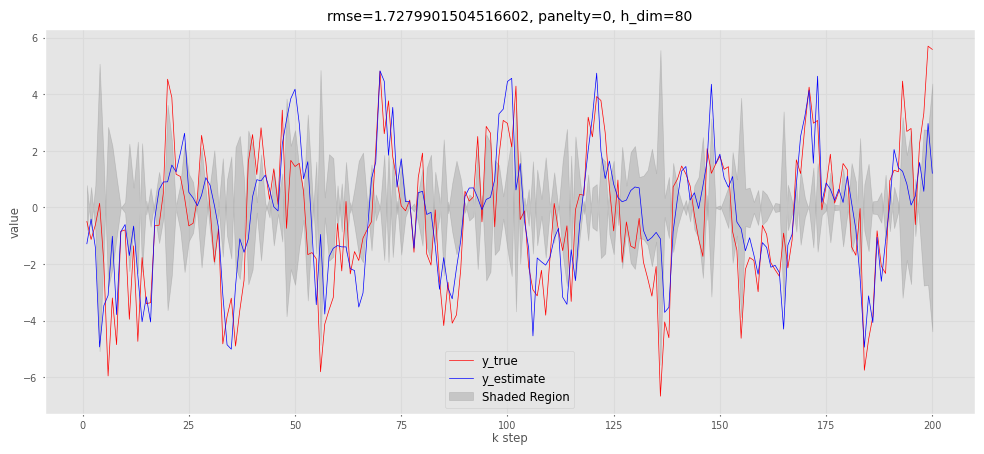

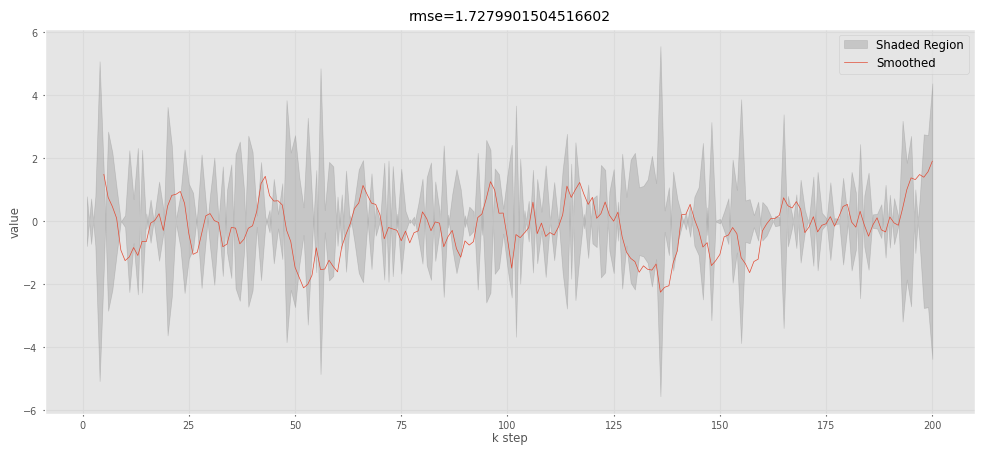

In [3]:

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/toy_lgssm_5_pre_h20_z2_n1_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/data/toy_lgssm_5_pre_h20_z2_n1_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 200, start_from=0)

[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [-1.2830224  -0.40986267 -1.4119698  ...  1.1228303   2.5706315
  4.4201913 ]
1.7279901504516602


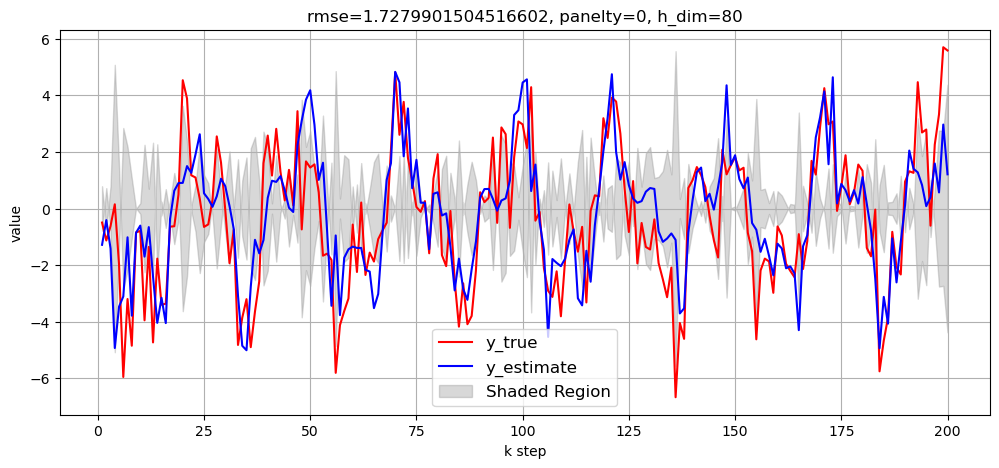

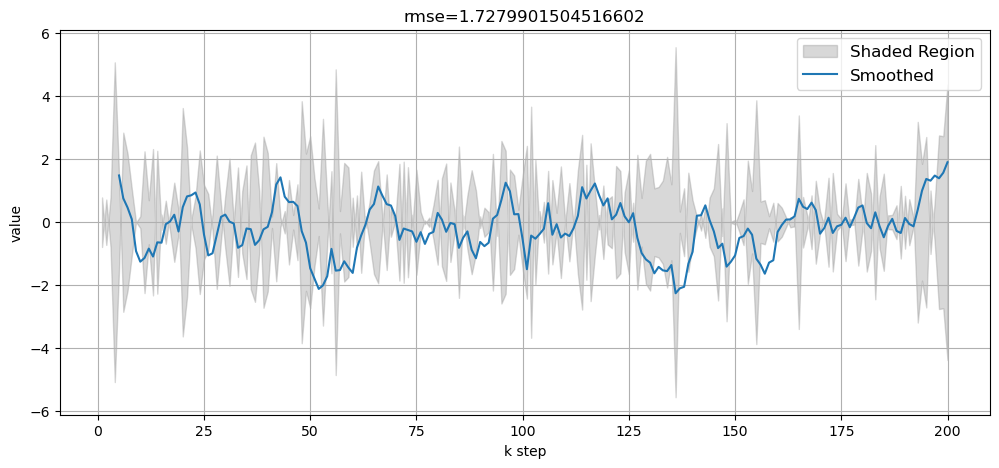

In [20]:

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/toy_lgssm_5_pre_h20_z2_n1_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/data/toy_lgssm_5_pre_h20_z2_n1_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 200, start_from=0)

[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [-0.17095007  0.15433809 -0.4179117  ...  2.2036924   2.501062
  4.044744  ]
1.558018684387207


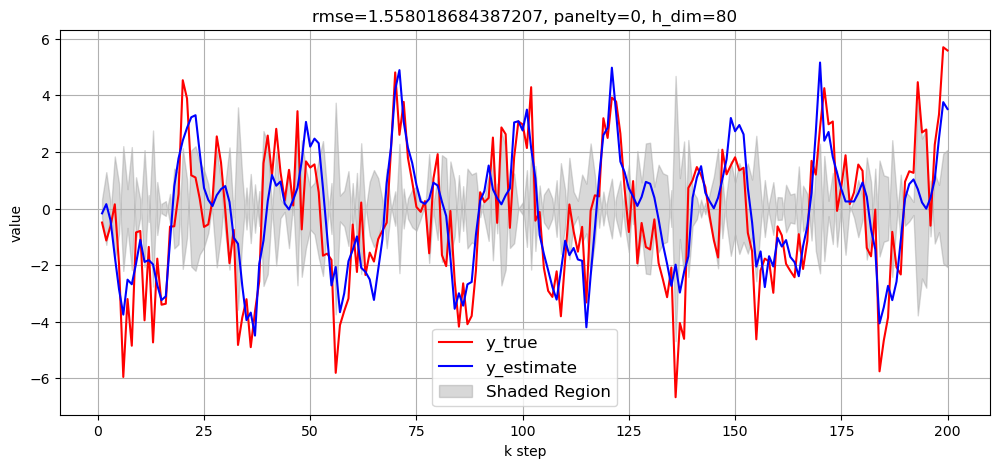

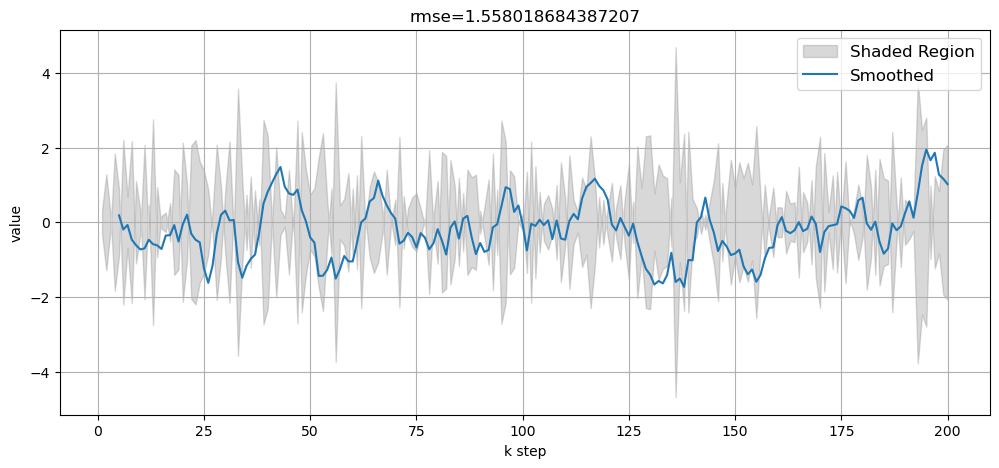

In [22]:

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/toy_lgssm_5_pre_h80_z10_n1_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/data/toy_lgssm_5_pre_h80_z10_n1_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 200, start_from=0)

[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [ 1.6850454e-01 -3.5505886e-03 -1.0433804e+00 ...  2.1727934e+00
  2.9511573e+00  4.5901337e+00]
1.5615674257278442


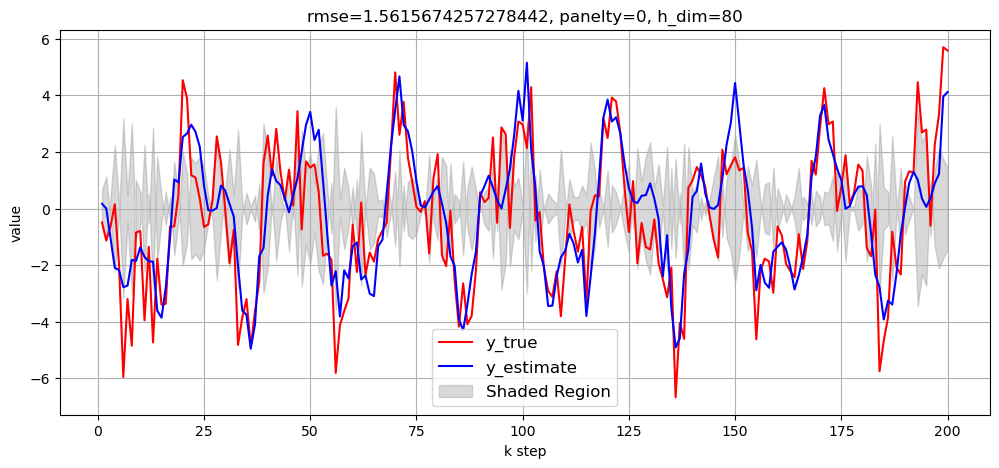

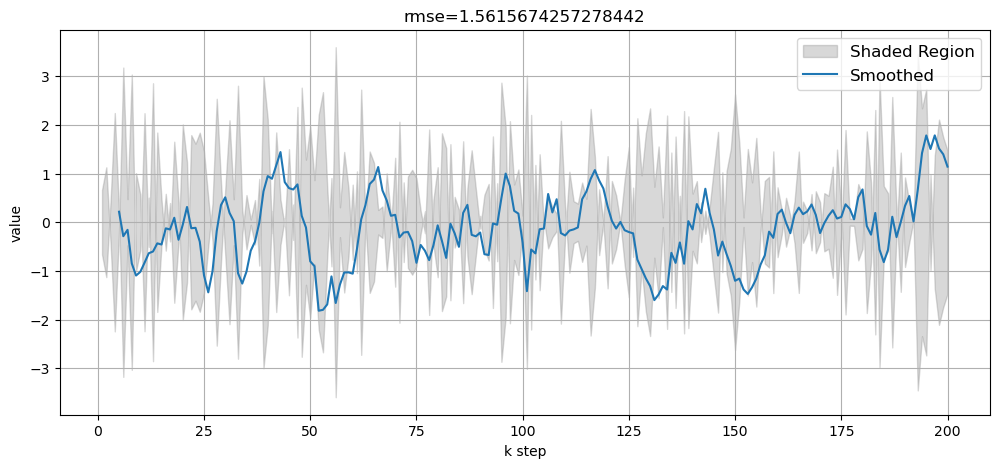

[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [ 1.6850454e-01 -3.5505886e-03 -1.0433804e+00 ...  2.1727934e+00
  2.9511573e+00  4.5901337e+00]
1.5615674257278442


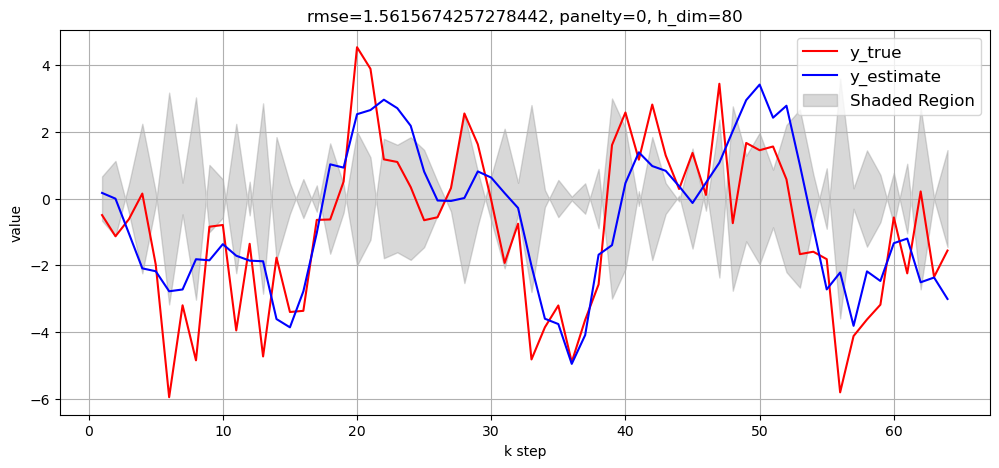

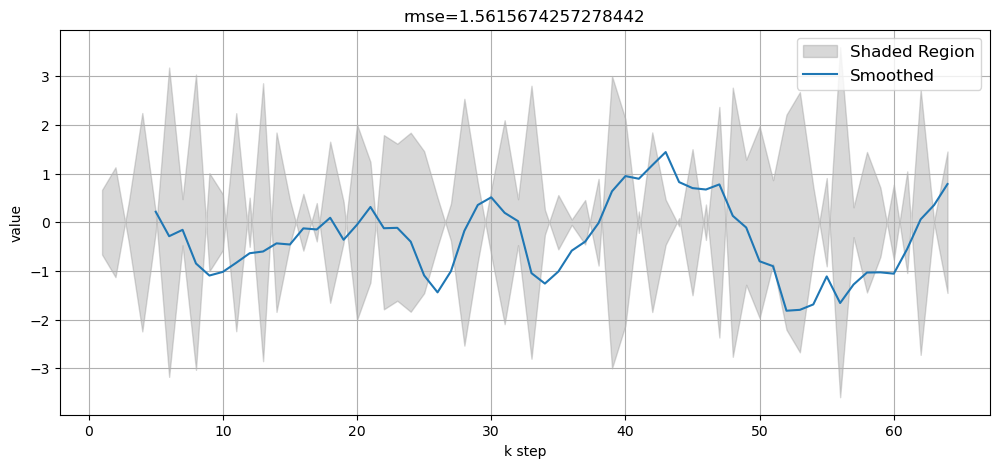

In [26]:


pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/toy_lgssm_5_pre_h80_z2_n1_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm_5_pre/AE-RNN_None/data/toy_lgssm_5_pre_h80_z2_n1_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 200, start_from=0)
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 64, start_from=0)

[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [-0.10366278  0.2380903  -0.33885065 ...  2.5436184   2.814575
  4.9169784 ]
1.8430859647849929


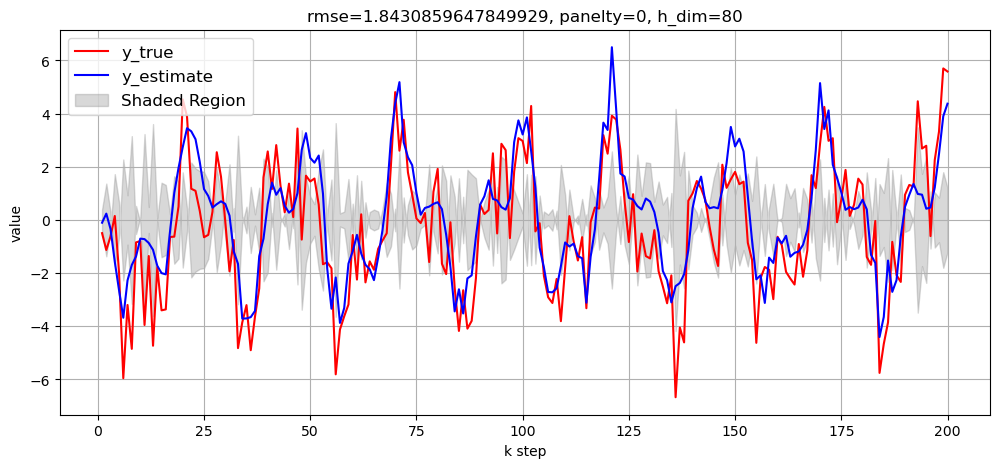

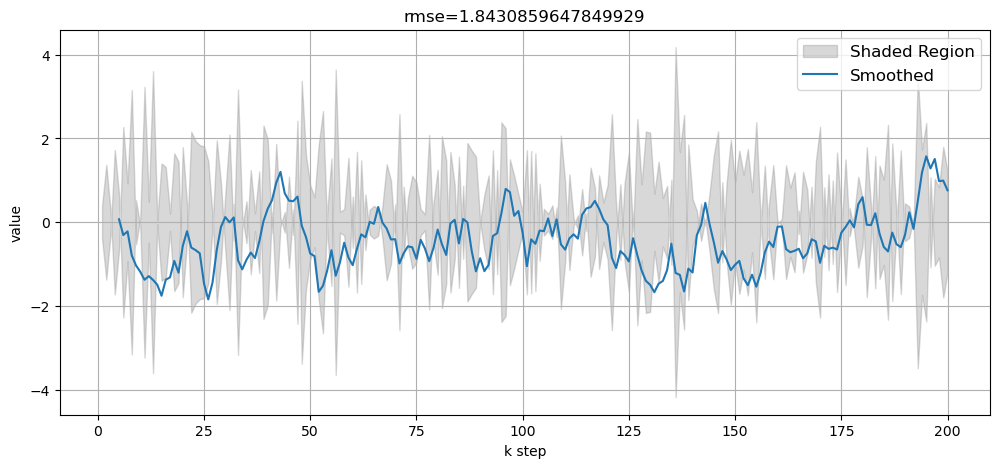

In [23]:

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm/AE-RNN_None/toy_lgssm_h80_z10_n1_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_relu/toy_lgssm/AE-RNN_None/data/toy_lgssm_h80_z10_n1_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=80,length = 200, start_from=0)

# var-rnn-phy


[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [-0.6183403   0.25413486 -1.1466817  ...  2.7865572   3.6778178
  3.619108  ]
1.5430543422698977


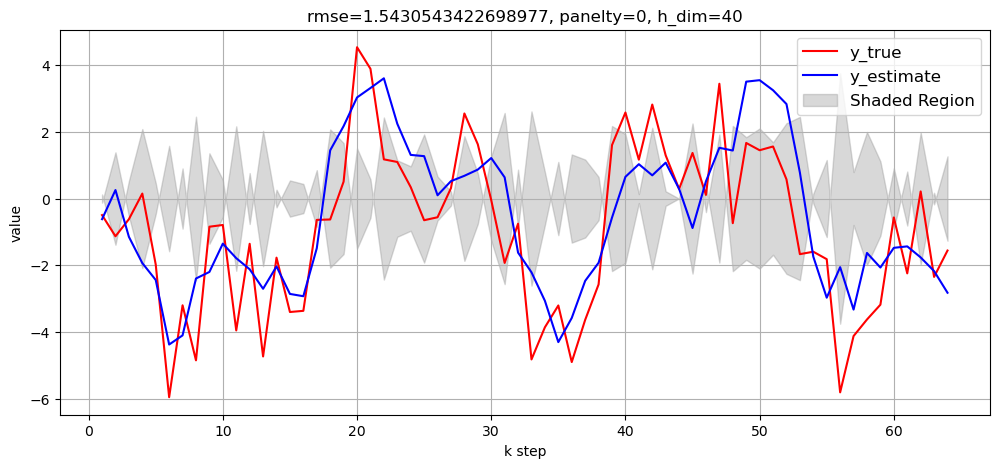

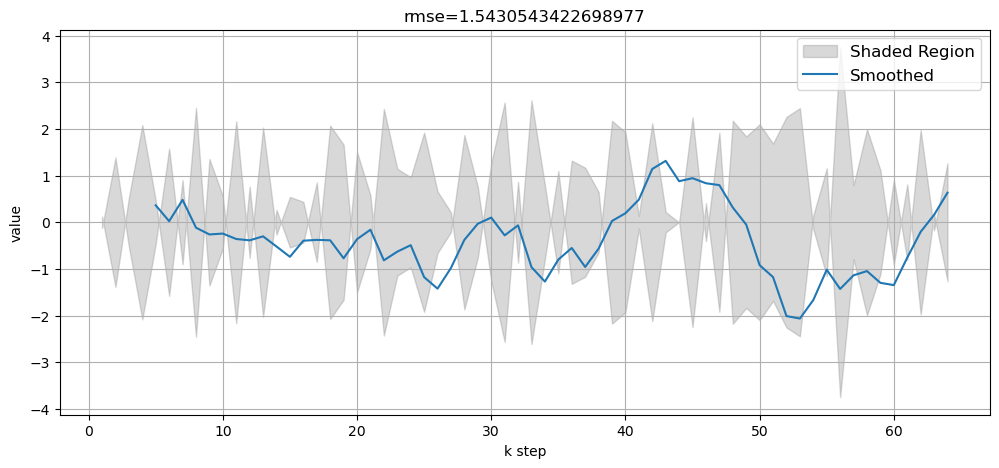

In [27]:

pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/parta0b0/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/toy_lgssm_5_pre_h80_z2_n1_mpw50_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/parta0b0/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/data/toy_lgssm_5_pre_h80_z2_n1_mpw50_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=40,length = 64, start_from=0)

[-0.49565518 -1.1304687  -0.61903954 ...  4.462914    4.948224
  3.9643989 ] [ 1.013878    1.0152053   1.041131   ... -0.03774927  0.7853611
  1.9083492 ]
2.9448060989379883


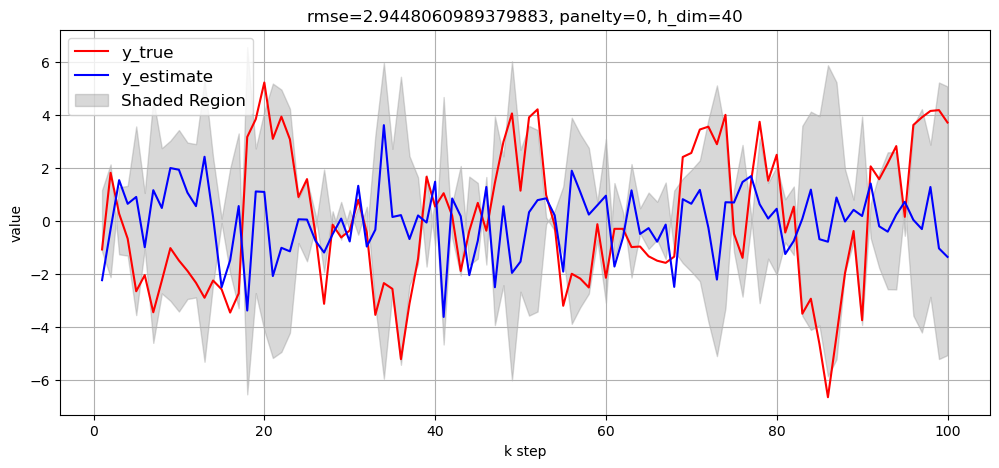

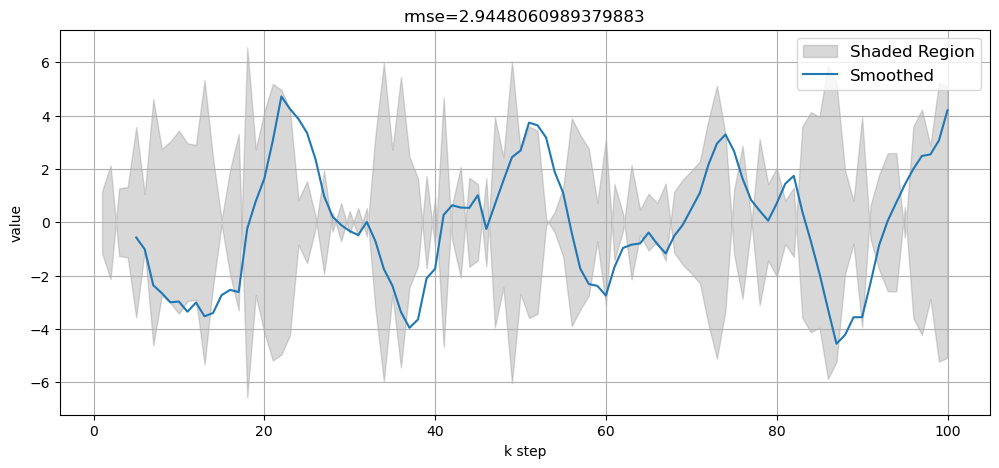

In [3]:


pattern = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prtallknow/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/toy_lgssm_5_pre_h20_z2_n1_mpw10000_A0_B0_estimation.csv"
rmse_path="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/prtallknow/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/data/toy_lgssm_5_pre_h20_z2_n1_mpw10000_A0_B0.csv"
y_yhat_nn(pattern, rmse_path,panelty=0,h_dim=40,length = 100, start_from=300)

#### read multi-rounds and get mean

In [3]:
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                print(root,name)
                result.append(os.path.join(root, name))
    return result
# pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h{}_z2_n1.csv"
def read_rsme(files, jump=1):
    rmse_value = []
    for i in range(0,len(files)):
        df = pd.read_csv(files[i])
        rmse_value.append(df["rmse"].mean()) 
    return rmse_value

def read_nrsme(files, jump=1):
    nrmse_value = []
    for i in range(0,len(files)):
        df = pd.read_csv(files[i])
        nrmse_value.append(df["nrmse"].mean()) 
    return nrmse_value

def read_std(files,jump=1):
    std_value = []
    for i in range(0,len(files)):
        df = pd.read_csv(files[i])
        std_value.append(df["std"].std()) 
    return std_value



file_path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/"
pattern = "*_multitrain.csv"
# find all files end with the patterns



multi_to_read = find(pattern,file_path)

# print(a)

/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/ toy_lgssm_5_pre_h60_z2_n1_mpw10000_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/ toy_lgssm_5_pre_h20_z2_n1_mpw10000_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/ toy_lgssm_5_pre_h100_z2_n1_mpw10000_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/ toy_lgssm_5_pre_h80_z2_n1_mpw10000_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/ toy_lgssm_5_pre_h10_z2_n1_mpw10000_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/ toy_lgssm_5_pre_h120_z2_n1_mpw10000_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/b

In [4]:
h_dim_max = 120
pattern = "*toy_lgssm_5_pre_h{}_z2_n1_mpw10000_A0_B0_multitrain.csv"
file_path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/"
pattern = "*_multitrain.csv"
# find all files end with the patterns
multi_to_read = find(pattern,file_path)
std_None_1 = read_std(multi_to_read, h_dim_max)
rsme_None_1 = read_rsme(multi_to_read, h_dim_max)


/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/ toy_lgssm_5_pre_h60_z2_n1_mpw10000_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/ toy_lgssm_5_pre_h20_z2_n1_mpw10000_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/ toy_lgssm_5_pre_h100_z2_n1_mpw10000_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/ toy_lgssm_5_pre_h80_z2_n1_mpw10000_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/ toy_lgssm_5_pre_h10_z2_n1_mpw10000_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test_hc/toy_lgssm_5_pre/VAE-RNN-PHYNN_None/ toy_lgssm_5_pre_h120_z2_n1_mpw10000_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/b

KeyError: 'std'

In [35]:
file_path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test/toy_lgssm_5_pre/VAE-RNN_None/"
pattern = "toy_lgssm_5_pre_h*_z10_n1_mpw0_A0_B0_multitrain.csv"
# find all files end with the patterns
multi_to_read = find(pattern,file_path)
std_None_1 = read_std(multi_to_read, h_dim_max)
rsme_None_1 = read_rsme(multi_to_read, h_dim_max)

/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test/toy_lgssm_5_pre/VAE-RNN_None/ toy_lgssm_5_pre_h80_z10_n1_mpw0_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test/toy_lgssm_5_pre/VAE-RNN_None/ toy_lgssm_5_pre_h60_z10_n1_mpw0_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test/toy_lgssm_5_pre/VAE-RNN_None/ toy_lgssm_5_pre_h100_z10_n1_mpw0_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test/toy_lgssm_5_pre/VAE-RNN_None/ toy_lgssm_5_pre_h40_z10_n1_mpw0_A0_B0_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/baseline_test/toy_lgssm_5_pre/VAE-RNN_None/ toy_lgssm_5_pre_h20_z10_n1_mpw0_A0_B0_multitrain.csv


In [36]:
rsme_None_1,std_None_1

([2.2485297679901124,
  2.2429337024688722,
  1.6232267379760743,
  2.6489140033721923,
  2.647281360626221],
 [0.5369149293404955,
  0.5517290537503287,
  0.028554829628474526,
  0.007294258836645143,
  0.005195803330867386])

### performance-length curve
1. nn
2. phy_aug_2
3. phy_aug_1
4. phy_aug_a
5. phy_gui_2
6. phy_gui_1
7. phy_gui_a

In [40]:
length = [200,500,1000,2000]
rmse_nn =       [1.461, 1.425, 1.395, 1.382]
rmse_phy_aug_2 = [1.381, 1.378, 1.368, 1.367]
rmse_phy_aug_1= [1.379, 1.378, 1.373, 1.378]
rmse_phy_gui_2 = [1.432, 1.396, 1.397, 1.388]
rmse_phy_gui_1 = [1.423, 1.397, 1.396, 1.389]

rmse_phy_aug_a = [1.400, 1.376, 1.370, 1.369]
rmse_phy_gui_a = [1.446, 1.408, 1.400, 1.385]




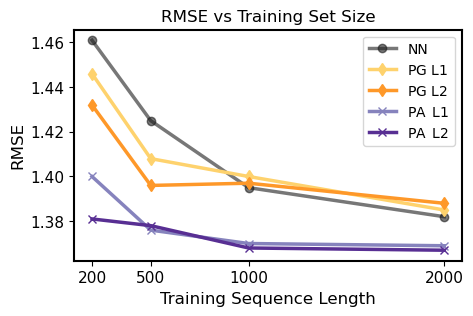

In [42]:
# Plotting the data
plt.figure(figsize=(5, 3))

plt.plot(length, rmse_nn, label='NN', marker='o',alpha = 0.6,linewidth=2.5,color=plt.cm.Greys(0.9))
plt.plot(length, rmse_phy_gui_a, label='PG{}L1'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.YlOrBr(0.32))
plt.plot(length, rmse_phy_gui_2, label='PG{}L2'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.YlOrBr(0.5))
plt.plot(length, rmse_phy_aug_a, label='PA{}L1'.format(r'$\,\,\,$'), marker='x',linewidth=2.5, color=plt.cm.Purples(0.6))
plt.plot(length, rmse_phy_aug_2, label='PA{}L2'.format(r'$\,\,\,$'), marker='x', linewidth=2.5, color=plt.cm.Purples(0.85))

# plt.plot(length, rmse_phy_gui_1, label='Phy_Gui 1', marker='^',linewidth=2.5)

# plt.plot(length, rmse_phy_aug_1, label='Phy_Aug 1', marker='s',linewidth=2.5)

# Adding title and labels
plt.title('RMSE vs Training Set Size',fontsize=12,color="black")
plt.xlabel('Training Sequence Length', fontsize=12,color="black")
# plt.xlabel('Length', fontsize=12,color="black")
plt.ylabel('RMSE', fontsize=12,color="black")


# Set x-ticks to display only the specific lengths
plt.xticks(length, fontsize=11, color="black")
plt.yticks(fontsize=11, color="black")
# Adding a legend
plt.legend(fontsize=10)

# Removing the grid
plt.grid(False)

# Adding a frame around the plot area
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
    
# Set background to white
ax.set_facecolor('white')
# Display the plot
# plt.show()

# Save the plot with high resolution
plt.savefig('high_res_plot.png', dpi=300, bbox_inches='tight')

# RNN

## function for posters

In [3]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load .mat file
mat_data = loadmat('/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/data/IndustRobo/y_sim.mat')
y_simulation = mat_data['y_sim']/180*np.pi


file_name_train = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/data/IndustRobo/forward_with_val_time.mat"
df_industRobo =  loadmat(file_name_train)
y_test  = df_industRobo["y_test"]/180*np.pi

csv_path_phy_guide="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_lr-3e/industrobo/AE-RNN_None/industrobo_h40_z12_n3_mpw-100_estimation.csv"
df = pd.read_csv(csv_path_phy_guide)
df.head()
y_phy_guided_3=df['y_sample_mu_3'].to_numpy().transpose()


csv_path_phy_guide="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/test_lr-3e/industrobo/AE-RNN_None/industrobo_h40_z12_n3_mpw-10_estimation.csv"
df = pd.read_csv(csv_path_phy_guide)
df.head()
y_NN_3=df['y_sample_mu_3'].to_numpy().transpose()



# y_test = mat_data['y_test']/180*np.pi




In [4]:
y_simulation[3]

array([ 0.00000000e+00, -2.77274618e-04, -8.35527811e-04, ...,
        5.83369562e-01,  5.92039511e-01,  6.00997564e-01])

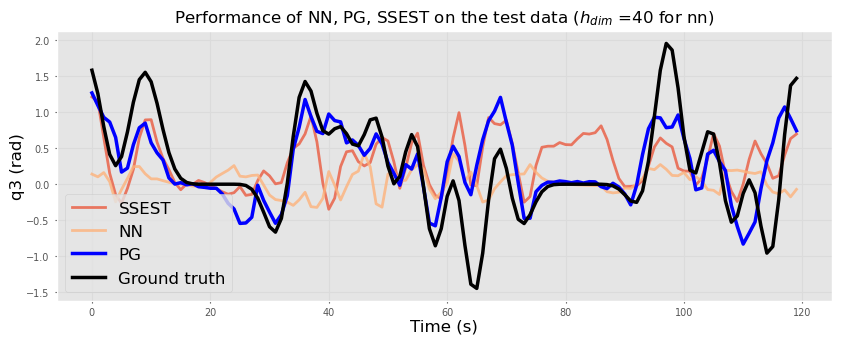

In [5]:
plt.figure(figsize=(10, 3.5))

plt.plot( y_simulation[3][::10][100:220], label='SSEST', markersize=8,alpha = 0.8, linewidth=2, color=plt.cm.OrRd(0.65))
# y_NN_3
plt.plot( y_NN_3[100:220], label='NN', markersize=8, alpha = 0.8,linewidth=2,color=plt.cm.OrRd(0.4))
plt.plot( y_phy_guided_3[100:220], label='PG', markersize=8, linewidth=2.5,color = 'blue')


plt.plot( y_test[3][::10][100:220], label='Ground truth', markersize=8, linewidth=2.5,linestyle='-', color='black')

plt.xlabel('Time (s)',fontsize=12,color="black")
plt.ylabel('q3 (rad)', fontsize=12,color="black")
plt.legend(fontsize=12,loc='lower left')
plt.title('Performance of NN, PG, SSEST on the test data ({} =40 for nn)'.format(r'$h_{dim}$'),fontsize=12,color="black")
plt.savefig('high_res_plot_q3.png', dpi=300, bbox_inches='tight')

##### 0802 performance curve

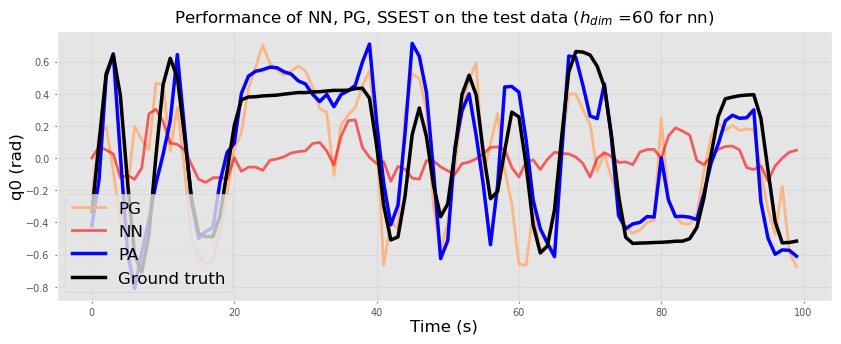

In [20]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load .mat file
mat_data = loadmat('/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/data/IndustRobo/y_sim.mat')
y_simulation = mat_data['y_sim']/180*np.pi


file_name_train = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/data/IndustRobo/simulated_simposition_rad.mat"
df_industRobo =  loadmat(file_name_train)
y_test  = df_industRobo["y_test"]/180*np.pi

# csv_path_phy_guide="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/07018_test_industrobo_ir-2_newsimulated_rad/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw-100_estimation.csv"
csv_path_phy_guide="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/07018_test_industrobo_ir-2_newsimulated_rad_dsam_1/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw-100_estimation.csv"

df = pd.read_csv(csv_path_phy_guide)
df.head()
y_phy_guided_4=df['y_sample_mu_0'].to_numpy().transpose()


csv_path_phy_guide="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/07018_test_industrobo_ir-2_newsimulated_rad_dsam_1/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw100_estimation.csv"
df = pd.read_csv(csv_path_phy_guide)
df.head()
y_phy_aug_4=df['y_sample_mu_0'].to_numpy().transpose()

csv_path_nn="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/07018_test_industrobo_ir-2_newsimulated_rad_dsam_1/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw-10_estimation.csv"
df = pd.read_csv(csv_path_nn)
df.head()
y_NN_4=df['y_sample_mu_0'].to_numpy().transpose()

y_test = y_test[:,::10]
plt.figure(figsize=(10, 3.5))
start_from = 100
end_at = 200
plt.plot( y_phy_guided_4[start_from:end_at], label='PG', markersize=8,alpha = 0.9, linewidth=2, color=plt.cm.OrRd(0.4))
# y_NN_1
plt.plot( y_NN_4[start_from:end_at], label='NN', markersize=8, alpha =0.6,linewidth=2,color='red')
plt.plot( y_phy_aug_4[start_from:end_at], label='PA', markersize=8,alpha =0.99, linewidth=2.5,color = 'blue')


plt.plot( y_test[0][start_from:end_at], label='Ground truth', markersize=8, linewidth=2.5,linestyle='-', color='black')

plt.xlabel('Time (s)',fontsize=12,color="black")
plt.ylabel('q0 (rad)', fontsize=12,color="black")
plt.legend(fontsize=12,loc='lower left')
plt.title('Performance of NN, PG, SSEST on the test data ({} =60 for nn)'.format(r'$h_{dim}$'),fontsize=12,color="black")
plt.savefig('high_res_plot_q0.png', dpi=300, bbox_inches='tight')

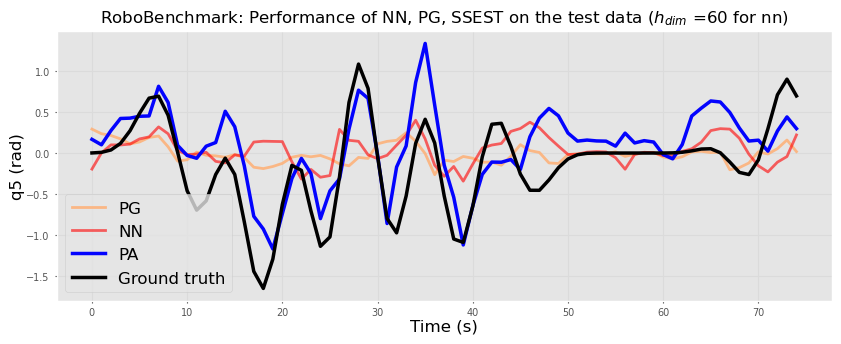

In [24]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load .mat file
mat_data = loadmat('/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/data/IndustRobo/y_sim.mat')
y_simulation = mat_data['y_sim']/180*np.pi


file_name_train = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/data/IndustRobo/forward_with_val.mat"
df_industRobo =  loadmat(file_name_train)
y_test  = df_industRobo["y_test"]/180*np.pi

# csv_path_phy_guide="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/07018_test_industrobo_ir-2_newsimulated_rad/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw-100_estimation.csv"
csv_path_phy_guide="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/07031_test_industrobo_ir-2_rad_dsam_1/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw-100_estimation.csv"

df = pd.read_csv(csv_path_phy_guide)
df.head()
y_phy_guided_4=df['y_sample_mu_5'].to_numpy().transpose()


csv_path_phy_guide="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/07031_test_industrobo_ir-2_rad_dsam_1/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw100_estimation.csv"
df = pd.read_csv(csv_path_phy_guide)
df.head()
y_phy_aug_4=df['y_sample_mu_5'].to_numpy().transpose()

csv_path_nn="/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/07031_test_industrobo_ir-2_rad_dsam_1/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw-10_estimation.csv"
df = pd.read_csv(csv_path_nn)
df.head()
y_NN_4=df['y_sample_mu_5'].to_numpy().transpose()

y_test = y_test[:,::10]
plt.figure(figsize=(10, 3.5))
start_from = 125
end_at = 200
plt.plot( y_phy_guided_4[start_from:end_at], label='PG', markersize=8,alpha = 0.9, linewidth=2, color=plt.cm.OrRd(0.4))
# y_NN_1
plt.plot( y_NN_4[start_from:end_at], label='NN', markersize=8, alpha =0.6,linewidth=2,color='red')
plt.plot( y_phy_aug_4[start_from:end_at], label='PA', markersize=8,alpha =0.99, linewidth=2.5,color = 'blue')


plt.plot( y_test[5][start_from:end_at], label='Ground truth', markersize=8, linewidth=2.5,linestyle='-', color='black')

plt.xlabel('Time (s)',fontsize=12,color="black")
plt.ylabel('q5 (rad)', fontsize=12,color="black")
plt.legend(fontsize=12,loc='lower left')
plt.title('RoboBenchmark: Performance of NN, PG, SSEST on the test data ({} =60 for nn)'.format(r'$h_{dim}$'),fontsize=12,color="black")
plt.savefig('high_res_plot_q5_real.png', dpi=300, bbox_inches='tight')

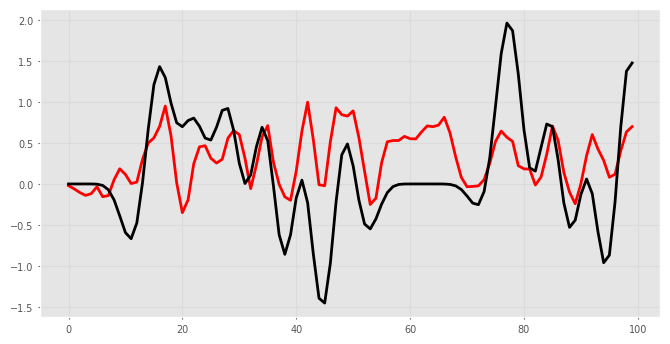

In [17]:
plt.figure(figsize=(8, 4))

plt.plot( y_simulation[3][::10][120:220], label='Phy_Aug Lev2', markersize=8,linewidth=2, color = 'red')

# plt.plot( y_phy_guided_3[120:220], label='Phy_Aug Lev2', markersize=8, linewidth=2,color = 'blue')

plt.plot( y_test[3][::10][120:220], label='Phy_Aug Lev2', markersize=8, linewidth=2,linestyle='-', color='black')

plt.figure(figsize=(8, 4))

# plt.plot( y_simulation[3][::10][100:220], label='Phy_Aug Lev2', markersize=8,linewidth=2, color = 'red')

plt.plot( y_phy_guided_3[120:220], label='Phy_Aug Lev2', markersize=8, linewidth=2,color = 'blue')

plt.plot( y_test[3][::10][120:220], label='Phy_Aug Lev2', markersize=8, linewidth=2,linestyle='-', color='black')





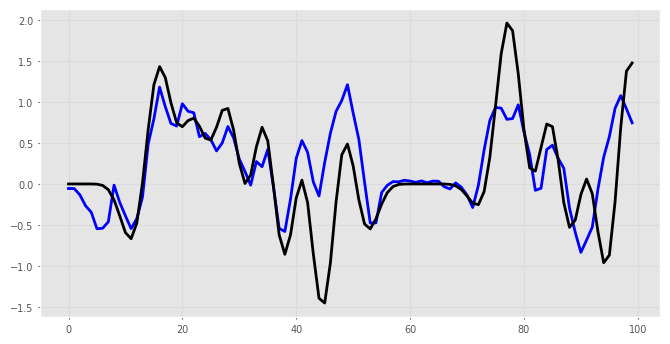

In [18]:
plt.figure(figsize=(8, 4))

# plt.plot( y_simulation[3][::10][100:220], label='Phy_Aug Lev2', markersize=8,linewidth=2, color = 'red')

plt.plot( y_phy_guided_3[120:220], label='Phy_Aug Lev2', markersize=8, linewidth=2,color = 'blue')

plt.plot( y_test[3][::10][120:220], label='Phy_Aug Lev2', markersize=8, linewidth=2,linestyle='-', color='black')



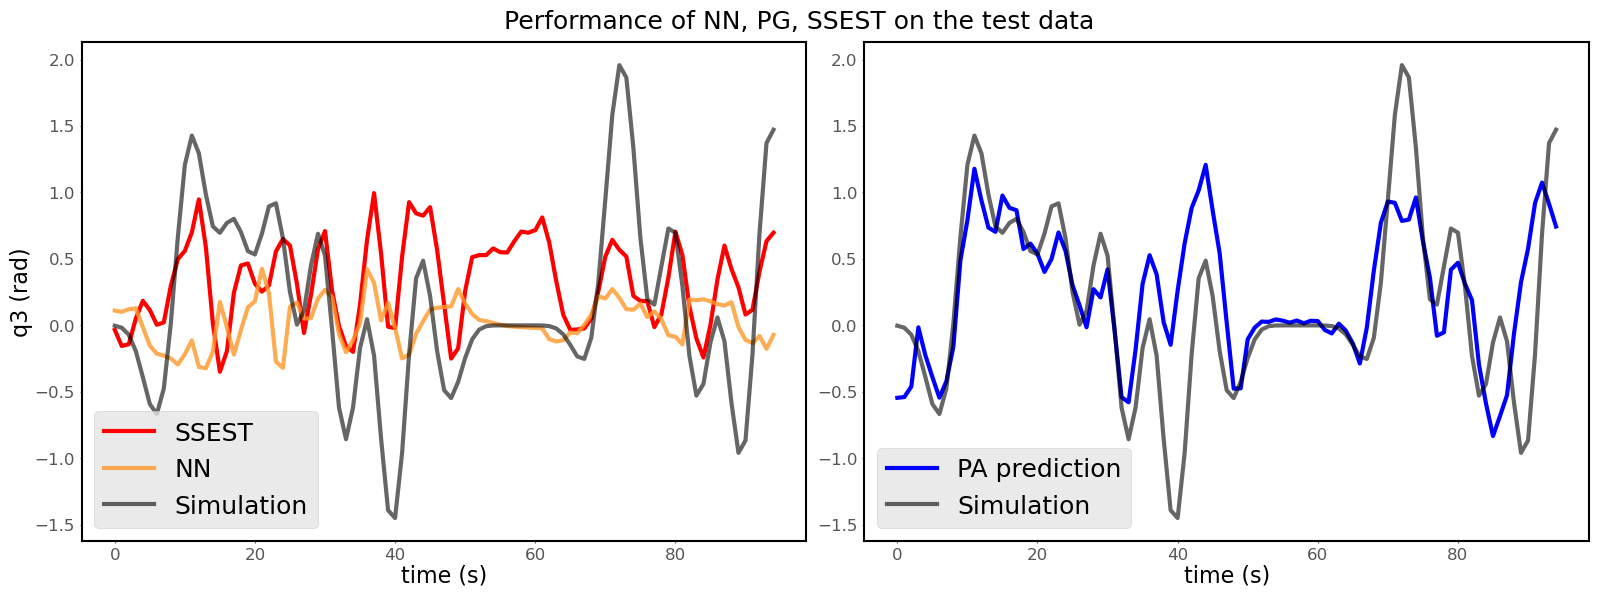

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot on the first subplot
ax1.plot(y_simulation[3][::10][125:220], label='SSEST', markersize=8, linewidth=3, color='red')
ax1.plot(y_NN_3[125:220], label='NN', markersize=8, linewidth=3, alpha = 0.8, color = plt.cm.YlOrBr(0.5))
ax1.plot(y_test[3][::10][125:220], label='Simulation',alpha = 0.6, markersize=8, linewidth=3, linestyle='-', color='black')
# ax1.set_title('Plot 1', fontsize=18,color="black")
ax1.set_xlabel('time (s)',fontsize=16,color="black")
ax1.set_ylabel('q3 (rad)', fontsize=16,color="black")
ax1.legend(fontsize=18,loc='lower left')

# Plot on the second subplot
ax2.plot(y_phy_guided_3[125:220], label='PA prediction', markersize=8, linewidth=3, color='blue')
ax2.plot(y_test[3][::10][125:220], label='Simulation',alpha = 0.6, markersize=8, linewidth=3, linestyle='-', color='black')
# ax2.set_title('Plot 2', fontsize=18,color="black")
ax2.set_xlabel('time (s)',fontsize=16,color="black")

ax2.legend(fontsize=18,loc='lower left')

# Set common properties
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    ax.set_facecolor('white')


# # Adding title and labels
fig.suptitle('Performance of NN, PG, SSEST on the test data',fontsize=18,color="black")
# plt.xlabel('Training Sequence Length', fontsize=14,color="black")
# # plt.xlabel('Length', fontsize=14,color="black")
# plt.ylabel('RMSE', fontsize=14,color="black")

# Adjust layout
plt.tight_layout()

# Display the plot
# plt.show()

# Save the plot with high resolution
plt.savefig('high_res_plot.png', dpi=300, bbox_inches='tight')

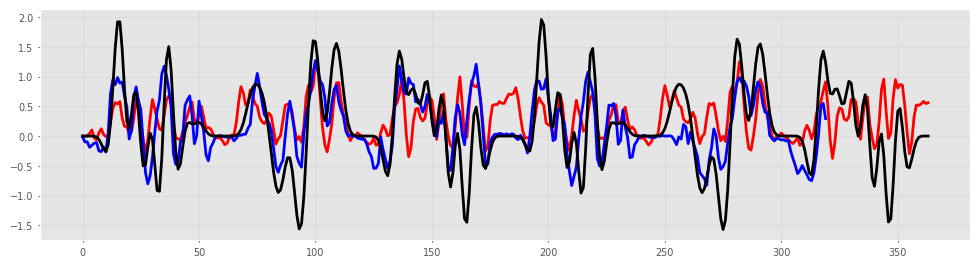

In [5]:
plt.figure(figsize=(12, 3))

plt.plot( y_simulation[3][::10], label='Phy_Aug Lev2', markersize=8, linewidth=2, color = 'red')

plt.plot( y_phy_guided_3, label='Phy_Aug Lev2', markersize=8, linewidth=2,color = 'blue')

plt.plot( y_test[3][::10], label='Phy_Aug Lev2', markersize=8, linewidth=2,linestyle='-', color='black')



## Function for nrmse analyse

In [4]:
def base_pg_pa(rmse_nn, rmse_phy_gui_a, rmse_phy_aug_a, rmse_phy,h_dim, log_path):
    plt.figure(figsize=(5, 3))
    length = [0,1,2,3,4,5]
    plt.plot(length, rmse_nn, label='NN', marker='o',alpha = 0.6,linewidth=2.5,color=plt.cm.Greys(0.9))
    plt.plot(length, rmse_phy_gui_a, label='PG'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.YlOrBr(0.32))
    # plt.plot(length, rmse_phy_gui_2, label='PG{}L2'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.YlOrBr(0.5))
    plt.plot(length, rmse_phy_aug_a, label='PA'.format(r'$\,\,\,$'), marker='x',linewidth=2.5, color=plt.cm.Purples(0.6))
    # plt.plot(length, rmse_phy, label='PHY',linestyle = ":",linewidth=2.5, color=plt.cm.Greys(0.6))
    


    # Adding title and labels
    plt.title('RMSE of joints h_dim = {}, {}'.format(h_dim,log_path),fontsize=12,color="black")
    plt.xlabel('Joints', fontsize=12,color="black")
    # plt.xlabel('Length', fontsize=12,color="black")
    plt.ylabel('NRMSE', fontsize=12,color="black")


    # Set x-ticks to display only the specific lengths
    plt.xticks(length, fontsize=11, color="black")
    plt.yticks(fontsize=11, color="black")
    # Adding a legend
    plt.legend(fontsize=10)

    # Removing the grid
    plt.grid(False)

    # Adding a frame around the plot area
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
        
    # Set background to white
    ax.set_facecolor('white')
    # Display the plot
    plt.show()

    # Save the plot with high resolution
    # plt.savefig('high_res_plot.png', dpi=300, bbox_inches='tight')



def multidim_pa(dim_1,dim_2, dim_3, log_path):
    plt.figure(figsize=(5, 3))
    length = [0,1,2,3,4,5]
    print(dim_1)
    plt.plot(length, dim_1, label='dim=20', marker='o',alpha = 0.6,linewidth=2.5,color=plt.cm.Purples(0.4))
    plt.plot(length, dim_2, label='dim=40'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.Purples(0.6))
    # plt.plot(length, rmse_phy_gui_2, label='PG{}L2'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.Purples(0.5))
    plt.plot(length, dim_3, label='dim=60'.format(r'$\,\,\,$'), marker='x',linewidth=2.5, color=plt.cm.Purples(0.8))
    # plt.plot(length, rmse_phy, label='PHY',linestyle = ":",linewidth=2.5, color=plt.cm.Greys(0.6))
    


    # Adding title and labels
    plt.title('PA: RMSE of joints {}'.format(log_path),fontsize=12,color="black")
    plt.xlabel('Joints', fontsize=12,color="black")
    # plt.xlabel('Length', fontsize=12,color="black")
    plt.ylabel('NRMSE', fontsize=12,color="black")


    # Set x-ticks to display only the specific lengths
    plt.xticks(length, fontsize=11, color="black")
    plt.yticks(fontsize=11, color="black")
    # Adding a legend
    plt.legend(fontsize=10)

    # Removing the grid
    plt.grid(False)

    # Adding a frame around the plot area
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
        
    # Set background to white
    ax.set_facecolor('white')
    # Display the plot
    plt.show()

    # Save the plot with high resolution
    # plt.savefig('high_res_plot.png', dpi=300, bbox_inches='tight')

def multidim_pg(dim_1,dim_2, dim_3, log_path):
    plt.figure(figsize=(5, 3))
    length = [0,1,2,3,4,5]
    plt.plot(length, dim_1, label='dim=20', marker='o',alpha = 0.6,linewidth=2.5,color=plt.cm.YlOrBr(0.4))
    plt.plot(length, dim_2, label='dim=40'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.YlOrBr(0.6))
    # plt.plot(length, rmse_phy_gui_2, label='PG{}L2'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.YlOrBr(0.5))
    plt.plot(length, dim_3, label='dim=60'.format(r'$\,\,\,$'), marker='x',linewidth=2.5, color=plt.cm.YlOrBr(0.8))
    # plt.plot(length, rmse_phy, label='PHY',linestyle = ":",linewidth=2.5, color=plt.cm.Greys(0.6))
    


    # Adding title and labels
    plt.title('PG: RMSE of joints {}'.format(log_path),fontsize=12,color="black")
    plt.xlabel('Joints', fontsize=12,color="black")
    # plt.xlabel('Length', fontsize=12,color="black")
    plt.ylabel('NRMSE', fontsize=12,color="black")


    # Set x-ticks to display only the specific lengths
    plt.xticks(length, fontsize=11, color="black")
    plt.yticks(fontsize=11, color="black")
    # Adding a legend
    plt.legend(fontsize=10)

    # Removing the grid
    plt.grid(False)

    # Adding a frame around the plot area
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
        
    # Set background to white
    ax.set_facecolor('white')
    # Display the plot
    plt.show()

    # Save the plot with high resolution
    # plt.savefig('high_res_plot.png', dpi=300, bbox_inches='tight')


def multidim_nn(dim_1,dim_2, dim_3, log_path):
    plt.figure(figsize=(5, 3))
    length = [0,1,2,3,4,5]
    plt.plot(length, dim_1, label='dim=20', marker='o',alpha = 0.6,linewidth=2.5,color=plt.cm.Greys(0.4))
    plt.plot(length, dim_2, label='dim=40'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.Greys(0.6))
    # plt.plot(length, rmse_phy_gui_2, label='PG{}L2'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.Greys(0.5))
    plt.plot(length, dim_3, label='dim=60'.format(r'$\,\,\,$'), marker='x',linewidth=2.5, color=plt.cm.Greys(0.8))
    # plt.plot(length, rmse_phy, label='PHY',linestyle = ":",linewidth=2.5, color=plt.cm.Greys(0.6))
    


    # Adding title and labels
    plt.title('NN: RMSE of joints {}'.format(log_path),fontsize=12,color="black")
    plt.xlabel('Joints', fontsize=12,color="black")
    # plt.xlabel('Length', fontsize=12,color="black")
    plt.ylabel('NRMSE', fontsize=12,color="black")


    # Set x-ticks to display only the specific lengths
    plt.xticks(length, fontsize=11, color="black")
    plt.yticks(fontsize=11, color="black")
    # Adding a legend
    plt.legend(fontsize=10)

    # Removing the grid
    plt.grid(False)

    # Adding a frame around the plot area
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
        
    # Set background to white
    ax.set_facecolor('white')
    # Display the plot
    plt.show()

    # Save the plot with high resolution
    # plt.savefig('high_res_plot.png', dpi=300, bbox_inches='tight')


def multidim_9(dim_1_pa,dim_2_pa, dim_3_pa,  dim_1_nn, dim_2_nn, dim_3_nn,dim_1_pg, dim_2_pg, dim_3_pg, log_path, if_named = False, dim_1_pa_name = "dim 20 PA",dim_2_pa_name = "dim 40 PA", dim_3_pa_name = "dim  60 PA",  dim_1_nn_name = "dim 20 NN ", dim_2_nn_name = "dim40 NN ", dim_3_nn_name = "dim 60 NN ",dim_1_pg_name = "dim 20 PG ", dim_2_pg_name = "dim40 PG ", dim_3_pg_name = "dim 60 PG "):
    plt.figure(figsize=(9, 9))
    length = [0,1,2,3,4,5]
    if if_named == True:
        plt.plot(length, dim_1_nn, label=dim_1_pa_name, marker='o',alpha = 0.6,linewidth=2,color=plt.cm.Greys(0.4))
        plt.plot(length, dim_2_nn, label=dim_2_pa_name.format(r'$\,\,$'), marker='d',linewidth=2, color=plt.cm.Greys(0.6))
        plt.plot(length, dim_3_nn, label=dim_3_pa_name.format(r'$\,\,\,$'), marker='x',linewidth=2, color=plt.cm.Greys(0.8))
        plt.plot(length, dim_1_pg, label=dim_1_nn_name, marker='o',alpha = 0.6,linewidth=2,color=plt.cm.YlOrBr(0.4))
        plt.plot(length, dim_2_pg, label=dim_2_nn_name.format(r'$\,\,$'), marker='d',linewidth=2, color=plt.cm.YlOrBr(0.6))
        plt.plot(length, dim_3_pg, label=dim_3_nn_name.format(r'$\,\,\,$'), marker='x',linewidth=2, color=plt.cm.YlOrBr(0.8))
        plt.plot(length, dim_1_pa, label=dim_1_pg_name, marker='o',alpha = 0.6,linewidth=2,color=plt.cm.Purples(0.4))
        plt.plot(length, dim_2_pa, label=dim_2_pg_name.format(r'$\,\,$'), marker='d',linewidth=2, color=plt.cm.Purples(0.6))
        plt.plot(length, dim_3_pa, label=dim_3_pg_name.format(r'$\,\,\,$'), marker='x',linewidth=2, color=plt.cm.Purples(0.8))

    else:
        plt.plot(length, dim_1_nn, label='dim=20 NN', marker='o',alpha = 0.6,linewidth=2,color=plt.cm.Greys(0.4))
        plt.plot(length, dim_2_nn, label='dim=40 NN'.format(r'$\,\,$'), marker='d',linewidth=2, color=plt.cm.Greys(0.6))
        plt.plot(length, dim_3_nn, label='dim=60 NN'.format(r'$\,\,\,$'), marker='x',linewidth=2, color=plt.cm.Greys(0.8))
        plt.plot(length, dim_1_pg, label='dim=20 PG', marker='o',alpha = 0.6,linewidth=2,color=plt.cm.YlOrBr(0.4))
        plt.plot(length, dim_2_pg, label='dim=40 PG'.format(r'$\,\,$'), marker='d',linewidth=2, color=plt.cm.YlOrBr(0.6))
        plt.plot(length, dim_3_pg, label='dim=60 PG'.format(r'$\,\,\,$'), marker='x',linewidth=2, color=plt.cm.YlOrBr(0.8))
        plt.plot(length, dim_1_pa, label='dim=20 PA', marker='o',alpha = 0.6,linewidth=2,color=plt.cm.Purples(0.4))
        plt.plot(length, dim_2_pa, label='dim=40 PA'.format(r'$\,\,$'), marker='d',linewidth=2, color=plt.cm.Purples(0.6))
        plt.plot(length, dim_3_pa, label='dim=60 PA'.format(r'$\,\,\,$'), marker='x',linewidth=2, color=plt.cm.Purples(0.8))


    # Adding title and labels
    plt.title('RMSE of joints {}'.format(log_path),fontsize=12,color="black")
    plt.xlabel('Joints', fontsize=12,color="black")
    # plt.xlabel('Length', fontsize=12,color="black")
    plt.ylabel('NRMSE', fontsize=12,color="black")


    # Set x-ticks to display only the specific lengths
    plt.xticks(length, fontsize=11, color="black")
    plt.yticks(fontsize=11, color="black")
    # Adding a legend
    plt.legend(fontsize=10)

    # Removing the grid
    plt.grid(False)

    # Adding a frame around the plot area
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
        
    # Set background to white
    ax.set_facecolor('white')
    # Display the plot
    plt.show()

    # Save the plot with high resolution
    # plt.savefig('high_res_plot.png', dpi=300, bbox_inches='tight')
    

def multidim_6(dim_1_pa,dim_2_pa,  dim_1_nn, dim_2_nn,dim_1_pg, dim_2_pg, log_path, if_named = False, dim_1_pa_name = "dim 20 PA", dim_2_pa_name = "dim 40 PA",   dim_1_nn_name = "dim 20 NN ", dim_2_nn_name = "dim40 NN ",dim_1_pg_name = "dim 20 PG ", dim_2_pg_name = "dim40 PG ", ):
    plt.figure(figsize=(9, 6))
    length = [0,1,2,3,4,5]
    if if_named == True:
        plt.plot(length, dim_1_nn, label=dim_1_nn_name, marker='o',alpha = 0.6,linewidth=2.5,color=plt.cm.Greys(0.4))
        plt.plot(length, dim_2_nn, label=dim_2_nn_name.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.Greys(0.6))
        
        plt.plot(length, dim_1_pg, label=dim_1_pg_name, marker='o',alpha = 0.6,linewidth=2.5,color=plt.cm.YlOrBr(0.4))
        plt.plot(length, dim_2_pg, label=dim_2_pg_name.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.YlOrBr(0.6))
       
        plt.plot(length, dim_1_pa, label=dim_1_pa_name, marker='o',alpha = 0.6,linewidth=2.5,color=plt.cm.Purples(0.4))
        plt.plot(length, dim_2_pa, label=dim_2_pa_name.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.Purples(0.6))
   

    else:
        plt.plot(length, dim_1_nn, label='dim=20 NN', marker='o',alpha = 0.6,linewidth=2.5,color=plt.cm.Greys(0.4))
        plt.plot(length, dim_2_nn, label='dim=40 NN'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.Greys(0.6))
        
        plt.plot(length, dim_1_pg, label='dim=20 PG', marker='o',alpha = 0.6,linewidth=2.5,color=plt.cm.YlOrBr(0.4))
        plt.plot(length, dim_2_pg, label='dim=40 PG'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.YlOrBr(0.6))
       
        plt.plot(length, dim_1_pa, label='dim=20 PA', marker='o',alpha = 0.6,linewidth=2.5,color=plt.cm.Purples(0.4))
        plt.plot(length, dim_2_pa, label='dim=40 PA'.format(r'$\,\,$'), marker='d',linewidth=2.5, color=plt.cm.Purples(0.6))
       
    # Adding title and labels
    plt.title('RMSE of joints {}'.format(log_path),fontsize=12,color="black")
    plt.xlabel('Joints', fontsize=12,color="black")
    # plt.xlabel('Length', fontsize=12,color="black")
    plt.ylabel('NRMSE', fontsize=12,color="black")


    # Set x-ticks to display only the specific lengths
    plt.xticks(length, fontsize=11, color="black")
    plt.yticks(fontsize=11, color="black")
    # Adding a legend
    plt.legend(fontsize=10)

    # Removing the grid
    plt.grid(False)

    # Adding a frame around the plot area
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
        
    # Set background to white
    ax.set_facecolor('white')
    # Display the plot
    plt.show()

    # Save the plot with high resolution
    # plt.savefig('high_res_plot.png', dpi=300, bbox_inches='tight')


def read_nrsme_file(file, ):    
    df = pd.read_csv(file)
    nrmse_value=df["nrmse"]
    return nrmse_value

def read_cc_file(file, ):    
    df = pd.read_csv(file)
    cc_value=df["Correlation Coefficient"]
    return cc_value


# dynamic_kuka300 = [2.3863023566476502, 0.7826491507038651, 1.3696806732562823, 3.0557376977372295, 3.2652532698044836, 2.5486718681672547]
# dynamic_puma = [3.5536932109640453, 4.18831311104298, 2.067651811093543, 1.117004962597081, 1.1203390464986163, 0.7402294711913071]
# dynamic_sim = [0.9114854009874692, 0.28518886317218467, 0.3526462328020691, 0.7990528088534209, 0.4620353708753438, 0.6759367982513729]






In [5]:
log_name = "0704_test_industrobo_ir-2_dsam"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim = "60"
nn_path = path.format(log_name,h_dim,"-10")
pa_path = path.format(log_name,h_dim,"100")
pg_path = path.format(log_name,h_dim,"-100")
print(nn_path)
rmse_nn=read_nrsme_file(nn_path)
rmse_phy_aug_a=read_nrsme_file(pa_path)
rmse_phy_gui_a=read_nrsme_file(pg_path)
base_pg_pa(rmse_nn, rmse_phy_gui_a, rmse_phy_aug_a, dynamic_kuka300, h_dim, log_name )

/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/0704_test_industrobo_ir-2_dsam/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw-10_multitrain.csv


NameError: name 'dynamic_kuka300' is not defined

/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/0704_test_industrobo_ir-2_dsam/industrobo/AE-RNN_None/industrobo_h40_z12_n3_mpw-10_multitrain.csv


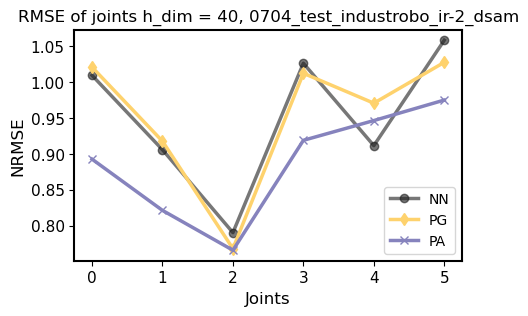

In [11]:
log_name = "0704_test_industrobo_ir-2_dsam"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim = "40"
nn_path = path.format(log_name,h_dim,"-10")
pa_path = path.format(log_name,h_dim,"100")
pg_path = path.format(log_name,h_dim,"-100")
print(nn_path)
rmse_nn=read_nrsme_file(nn_path)
rmse_phy_aug_a=read_nrsme_file(pa_path)
rmse_phy_gui_a=read_nrsme_file(pg_path)
base_pg_pa(rmse_nn, rmse_phy_gui_a, rmse_phy_aug_a, dynamic_kuka300, h_dim, log_name )

/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/0704_test_industrobo_ir-2_dsam/industrobo/AE-RNN_None/industrobo_h20_z12_n3_mpw-10_multitrain.csv


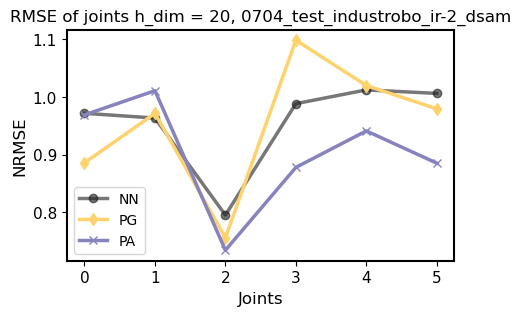

In [12]:
log_name = "0704_test_industrobo_ir-2_dsam"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim = "20"
nn_path = path.format(log_name,h_dim,"-10")
pa_path = path.format(log_name,h_dim,"100")
pg_path = path.format(log_name,h_dim,"-100")
print(nn_path)
rmse_nn=read_nrsme_file(nn_path)
rmse_phy_aug_a=read_nrsme_file(pa_path)
rmse_phy_gui_a=read_nrsme_file(pg_path)
base_pg_pa(rmse_nn, rmse_phy_gui_a, rmse_phy_aug_a, dynamic_kuka300, h_dim, log_name )

/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/0704_test_industrobo_ir-2_dsam/industrobo/AE-RNN_None/industrobo_h20_z12_n3_mpw-10_multitrain.csv


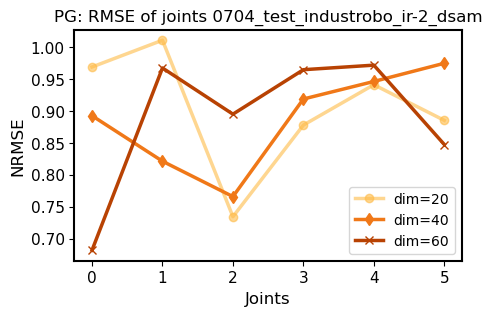

In [13]:
# physics-augment

log_name = "0704_test_industrobo_ir-2_dsam"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim1 = "20"
h_dim2 = "40"
h_dim3 = "60"


dim_1_path_pg = path.format(log_name,h_dim1,"100")
dim_2_path_pg = path.format(log_name,h_dim2,"100")
dim_3_path_pg = path.format(log_name,h_dim3,"100")
print(nn_path)
rmse_dim_1_pg=read_nrsme_file(dim_1_path_pg)
rmse_dim_2_pg=read_nrsme_file(dim_2_path_pg)
rmse_dim_3_pg=read_nrsme_file(dim_3_path_pg)



multidim_pg(rmse_dim_1_pg, rmse_dim_2_pg, rmse_dim_3_pg, log_name)

/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/0704_test_industrobo_ir-2_dsam/industrobo/AE-RNN_None/industrobo_h20_z12_n3_mpw-10_multitrain.csv /home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/0704_test_industrobo_ir-2_dsam/industrobo/AE-RNN_None/industrobo_h20_z12_n3_mpw-100_multitrain.csv
0    0.885931
1    0.971732
2    0.755912
3    1.098723
4    1.020117
5    0.979767
Name: nrmse, dtype: float64
0    0.885931
1    0.971732
2    0.755912
3    1.098723
4    1.020117
5    0.979767
Name: nrmse, dtype: float64


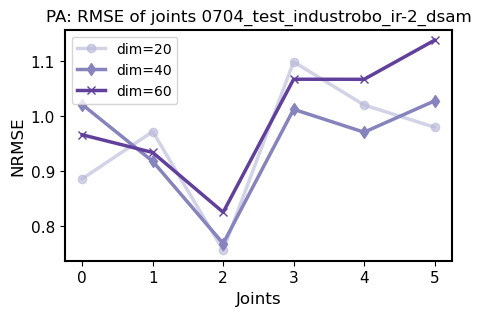

In [20]:
# physics-augment

log_name = "0704_test_industrobo_ir-2_dsam"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim1 = "20"
h_dim2 = "40"
h_dim3 = "60"


dim_1_path_pa = path.format(log_name,h_dim1,"-100")
dim_2_path_pa = path.format(log_name,h_dim2,"-100")
dim_3_path_pa = path.format(log_name,h_dim3,"-100")
print(nn_path,dim_1_path_pa)
rmse_dim_1_pa=read_nrsme_file(dim_1_path_pa)
rmse_dim_2_pa=read_nrsme_file(dim_2_path_pa)
rmse_dim_3_pa=read_nrsme_file(dim_3_path_pa)
print(rmse_dim_1_pa)
multidim_pa(rmse_dim_1_pa, rmse_dim_2_pa, rmse_dim_3_pa, log_name)

/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/0704_test_industrobo_ir-2_dsam/industrobo/AE-RNN_None/industrobo_h20_z12_n3_mpw-10_multitrain.csv


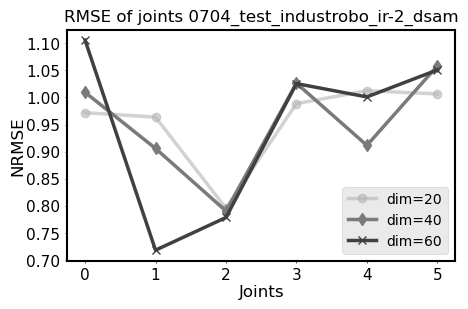

In [ ]:
# physics-augment

log_name = "0704_test_industrobo_ir-2_dsam"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim1 = "20"
h_dim2 = "40"
h_dim3 = "60"


dim_1_path_nn = path.format(log_name,h_dim1,"-10")
dim_2_path_nn = path.format(log_name,h_dim2,"-10")
dim_3_path_nn = path.format(log_name,h_dim3,"-10")
print(nn_path)
rmse_dim_1_nn=read_nrsme_file(dim_1_path_nn)
rmse_dim_2_nn=read_nrsme_file(dim_2_path_nn)
rmse_dim_3_nn=read_nrsme_file(dim_3_path_nn)
multidim_nn(rmse_dim_1_nn, rmse_dim_2_nn, rmse_dim_3_nn, log_name)

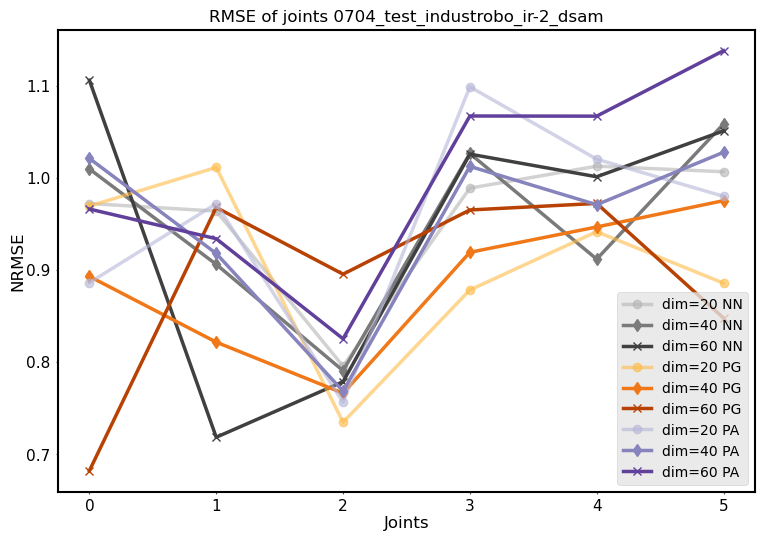

In [46]:
multidim_9(rmse_dim_1_pa, rmse_dim_2_pa, rmse_dim_3_pa, rmse_dim_1_nn, rmse_dim_2_nn, rmse_dim_3_nn, rmse_dim_1_pg, rmse_dim_2_pg, rmse_dim_3_pg, log_name)

/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/0704_test_industrobo_ir-2/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw-10_multitrain.csv


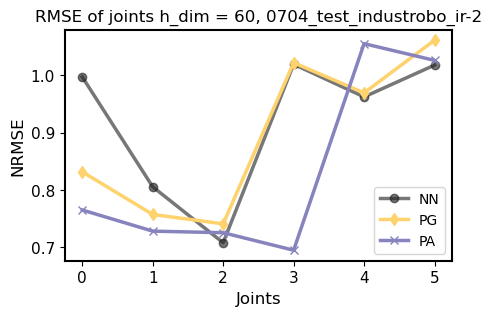

In [22]:
path  = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
log_name = "0704_test_industrobo_ir-2"
h_dim = "60"
nn_path = path.format(log_name,h_dim,"-10")
pa_path = path.format(log_name,h_dim,"100")
pg_path = path.format(log_name,h_dim,"-100")
print(nn_path)
rmse_nn=read_nrsme_file(nn_path)
rmse_phy_aug_a=read_nrsme_file(pa_path)
rmse_phy_gui_a=read_nrsme_file(pg_path)
base_pg_pa(rmse_nn, rmse_phy_gui_a, rmse_phy_aug_a, dynamic_kuka300, h_dim, log_name )

/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/0704_test_industrobo_ir-2_dsam/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw-10_multitrain.csv


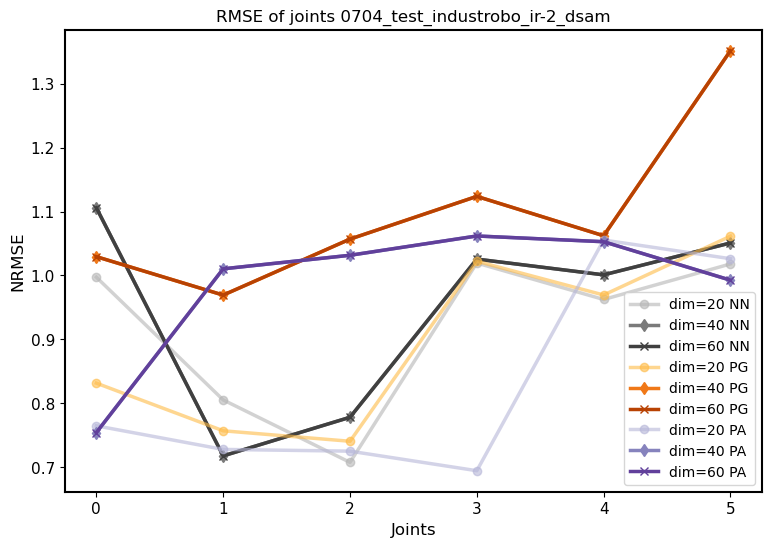

In [24]:
log_name = "0704_test_industrobo_ir-2_dsam"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim = "60"
nn_path = path.format(log_name,h_dim,"-10")
pa_path = path.format(log_name,h_dim,"100")
pg_path = path.format(log_name,h_dim,"-100")
print(nn_path)
rmse_nn_downsam=read_nrsme_file(nn_path)
rmse_phy_aug_a_downsam=read_nrsme_file(pa_path)
rmse_phy_gui_a_downsam=read_nrsme_file(pg_path)

# 20 is original
# 40/60 is down sampled
multidim_9(rmse_phy_aug_a, rmse_phy_aug_a_downsam, rmse_phy_aug_a_downsam, rmse_nn, rmse_nn_downsam, rmse_nn_downsam, rmse_phy_gui_a, rmse_phy_gui_a_downsam, rmse_phy_gui_a_downsam, log_name)

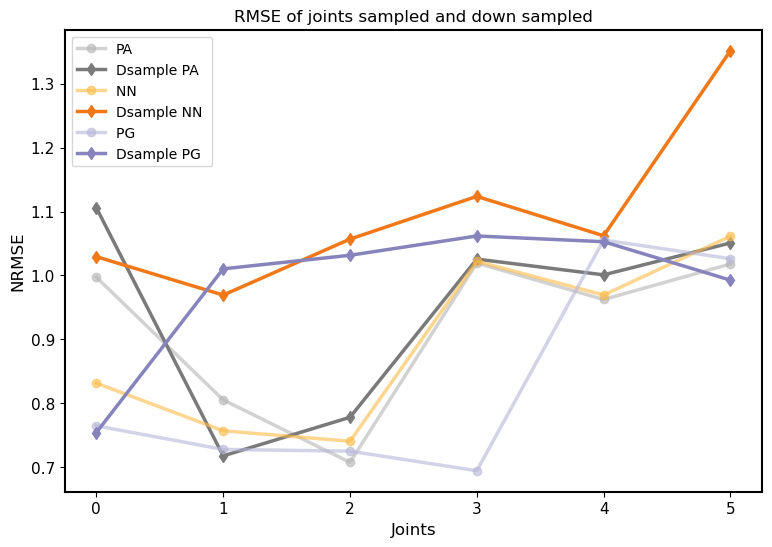

In [28]:



multidim_6(rmse_phy_aug_a, rmse_phy_aug_a_downsam, rmse_nn, rmse_nn_downsam, rmse_phy_gui_a, rmse_phy_gui_a_downsam, "sampled and down sampled", if_named = True, dim_1_pa_name = "PA", dim_2_pa_name = "Dsample PA",   dim_1_nn_name = "NN ", dim_2_nn_name = "Dsample NN ",dim_1_pg_name = "PG ", dim_2_pg_name = "Dsample PG ", )

/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/0704_test_industrobo_ir-2_dsam/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw-10_multitrain.csv
/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/0704_test_industrobo_ir-2_dsam/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw-10_multitrain.csv


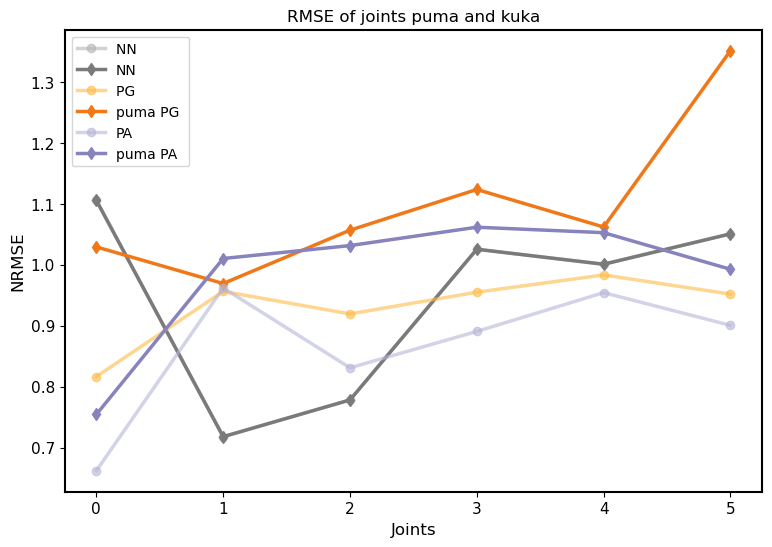

In [34]:

log_name = "0704_test_industrobo_ir-2_dsam"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim = "60"
nn_path = path.format(log_name,h_dim,"-10")
pa_path = path.format(log_name,h_dim,"100")
pg_path = path.format(log_name,h_dim,"-100")
print(nn_path)
rmse_nn_downsam=read_nrsme_file(nn_path)
rmse_phy_aug_a_downsam=read_nrsme_file(pa_path)
rmse_phy_gui_a_downsam=read_nrsme_file(pg_path)

log_name = "0704_test_industrobo_ir-2_dsam_puma"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim = "60"
# nn_path = path.format(log_name,h_dim,"-10")
pa_path = path.format(log_name,h_dim,"100")
pg_path = path.format(log_name,h_dim,"-100")
print(nn_path)
# rmse_nn_downsamm_puma=read_nrsme_file(nn_path)
rmse_phy_aug_a_downsamm_puma=read_nrsme_file(pa_path)
rmse_phy_gui_a_downsamm_puma=read_nrsme_file(pg_path)

multidim_6(rmse_phy_aug_a_downsamm_puma, rmse_phy_aug_a_downsam, rmse_nn_downsam, rmse_nn_downsam, rmse_phy_gui_a_downsamm_puma, rmse_phy_gui_a_downsam, "puma and kuka", if_named = True, dim_1_pa_name = "PA", dim_2_pa_name = "puma PA",   dim_1_nn_name = "NN ", dim_2_nn_name = "NN",dim_1_pg_name = "PG ", dim_2_pg_name = "puma PG ", )

/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/0704_test_industrobo_ir-2_dsam/industrobo/AE-RNN_None/industrobo_h60_z12_n3_mpw-10_multitrain.csv


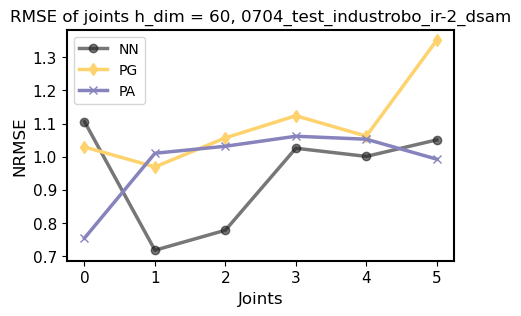

In [36]:
path  = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
log_name = "0704_test_industrobo_ir-2_dsam"
h_dim = "60"
nn_path = path.format(log_name,h_dim,"-10")
pa_path = path.format(log_name,h_dim,"100")
pg_path = path.format(log_name,h_dim,"-100")
print(nn_path)
rmse_nn=read_nrsme_file(nn_path)
rmse_phy_aug_a=read_nrsme_file(pa_path)
rmse_phy_gui_a=read_nrsme_file(pg_path)
base_pg_pa(rmse_nn, rmse_phy_gui_a, rmse_phy_aug_a, dynamic_kuka300, h_dim, log_name )

In [ ]:
path  = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
log_name = "0704_test_industrobo_ir-2_dsam"
h_dim = "60"
nn_path = path.format(log_name,h_dim,"-10")
pa_path = path.format(log_name,h_dim,"100")
pg_path = path.format(log_name,h_dim,"-100")
print(nn_path)
rmse_nn=read_nrsme_file(nn_path)
rmse_phy_aug_a=read_nrsme_file(pa_path)
rmse_phy_gui_a=read_nrsme_file(pg_path)
base_pg_pa(rmse_nn, rmse_phy_gui_a, rmse_phy_aug_a, dynamic_kuka300, h_dim, log_name )

### 07011_test_industrobo_ir-2_dsam_simulated

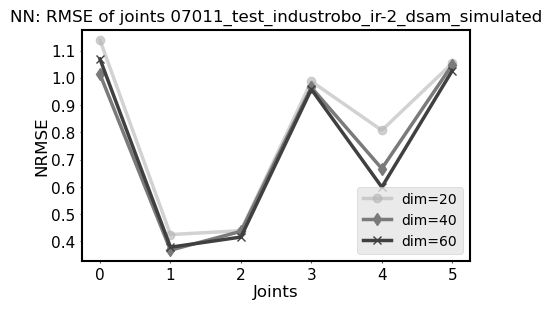

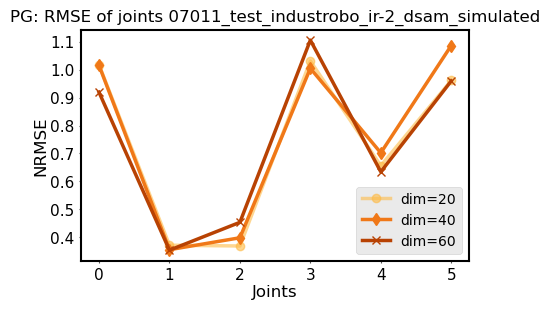

0    1.060212
1    0.498456
2    0.464801
3    1.087669
4    0.685612
5    1.112487
Name: nrmse, dtype: float64


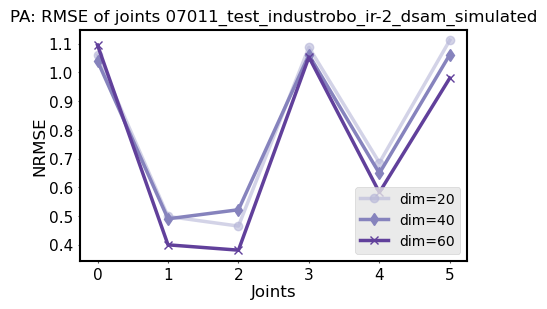

In [9]:
# physics-augment

log_name = "07011_test_industrobo_ir-2_dsam_simulated"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim1 = "20"
h_dim2 = "40"
h_dim3 = "60"


dim_1_path_nn = path.format(log_name,h_dim1,"-10")
dim_2_path_nn = path.format(log_name,h_dim2,"-10")
dim_3_path_nn = path.format(log_name,h_dim3,"-10")

rmse_dim_1_nn=read_nrsme_file(dim_1_path_nn)
rmse_dim_2_nn=read_nrsme_file(dim_2_path_nn)
rmse_dim_3_nn=read_nrsme_file(dim_3_path_nn)
multidim_nn(rmse_dim_1_nn, rmse_dim_2_nn, rmse_dim_3_nn, log_name)

# physics-augment


dim_1_path_pg = path.format(log_name,h_dim1,"100")
dim_2_path_pg = path.format(log_name,h_dim2,"100")
dim_3_path_pg = path.format(log_name,h_dim3,"100")

rmse_dim_1_pg=read_nrsme_file(dim_1_path_pg)
rmse_dim_2_pg=read_nrsme_file(dim_2_path_pg)
rmse_dim_3_pg=read_nrsme_file(dim_3_path_pg)



multidim_pg(rmse_dim_1_pg, rmse_dim_2_pg, rmse_dim_3_pg, log_name)

# physics-augment

dim_1_path_pa = path.format(log_name,h_dim1,"-100")
dim_2_path_pa = path.format(log_name,h_dim2,"-100")
dim_3_path_pa = path.format(log_name,h_dim3,"-100")

rmse_dim_1_pa=read_nrsme_file(dim_1_path_pa)
rmse_dim_2_pa=read_nrsme_file(dim_2_path_pa)
rmse_dim_3_pa=read_nrsme_file(dim_3_path_pa)

multidim_pa(rmse_dim_1_pa, rmse_dim_2_pa, rmse_dim_3_pa, log_name)

#### 9-curve plot

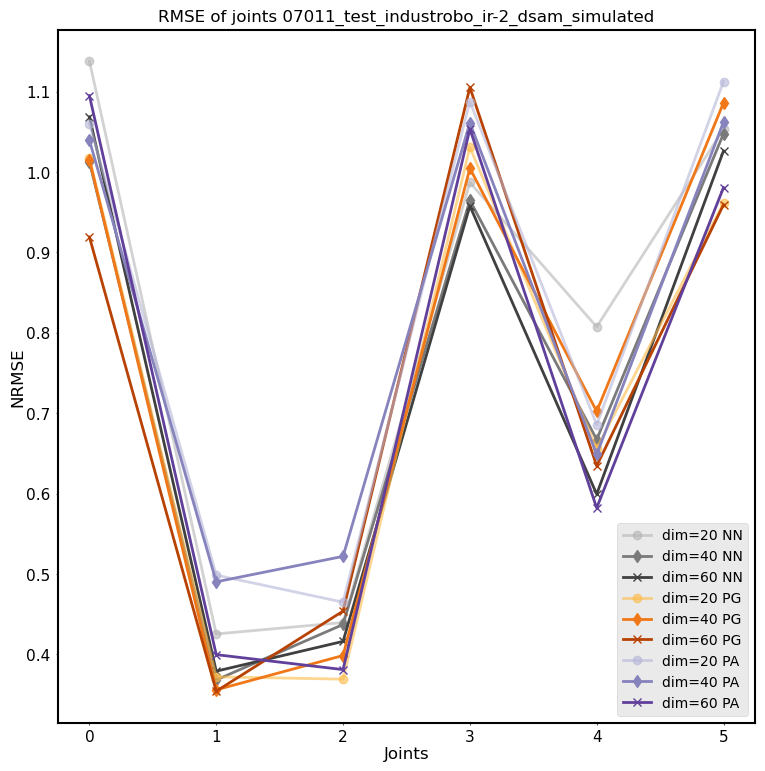

In [15]:
multidim_9(rmse_dim_1_pa, rmse_dim_2_pa, rmse_dim_3_pa, rmse_dim_1_nn, rmse_dim_2_nn, rmse_dim_3_nn, rmse_dim_1_pg, rmse_dim_2_pg, rmse_dim_3_pg, log_name)

### 07011_test_industrobo_ir-2_simulated

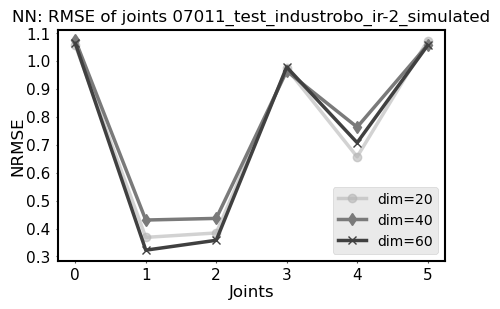

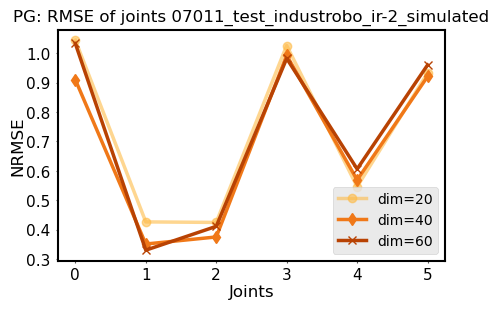

0    1.104578
1    0.440049
2    0.403986
3    1.013990
4    0.709512
5    1.047230
Name: nrmse, dtype: float64


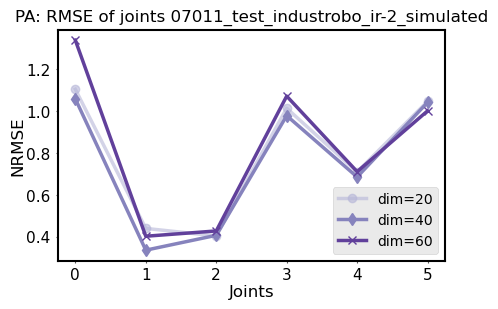

In [16]:
# physics-augment

log_name = "07011_test_industrobo_ir-2_simulated"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim1 = "20"
h_dim2 = "40"
h_dim3 = "60"


dim_1_path_nn = path.format(log_name,h_dim1,"-10")
dim_2_path_nn = path.format(log_name,h_dim2,"-10")
dim_3_path_nn = path.format(log_name,h_dim3,"-10")

rmse_dim_1_nn=read_nrsme_file(dim_1_path_nn)
rmse_dim_2_nn=read_nrsme_file(dim_2_path_nn)
rmse_dim_3_nn=read_nrsme_file(dim_3_path_nn)
multidim_nn(rmse_dim_1_nn, rmse_dim_2_nn, rmse_dim_3_nn, log_name)

# physics-augment


dim_1_path_pg = path.format(log_name,h_dim1,"100")
dim_2_path_pg = path.format(log_name,h_dim2,"100")
dim_3_path_pg = path.format(log_name,h_dim3,"100")

rmse_dim_1_pg=read_nrsme_file(dim_1_path_pg)
rmse_dim_2_pg=read_nrsme_file(dim_2_path_pg)
rmse_dim_3_pg=read_nrsme_file(dim_3_path_pg)



multidim_pg(rmse_dim_1_pg, rmse_dim_2_pg, rmse_dim_3_pg, log_name)

# physics-augment

dim_1_path_pa = path.format(log_name,h_dim1,"-100")
dim_2_path_pa = path.format(log_name,h_dim2,"-100")
dim_3_path_pa = path.format(log_name,h_dim3,"-100")

rmse_dim_1_pa=read_nrsme_file(dim_1_path_pa)
rmse_dim_2_pa=read_nrsme_file(dim_2_path_pa)
rmse_dim_3_pa=read_nrsme_file(dim_3_path_pa)

multidim_pa(rmse_dim_1_pa, rmse_dim_2_pa, rmse_dim_3_pa, log_name)

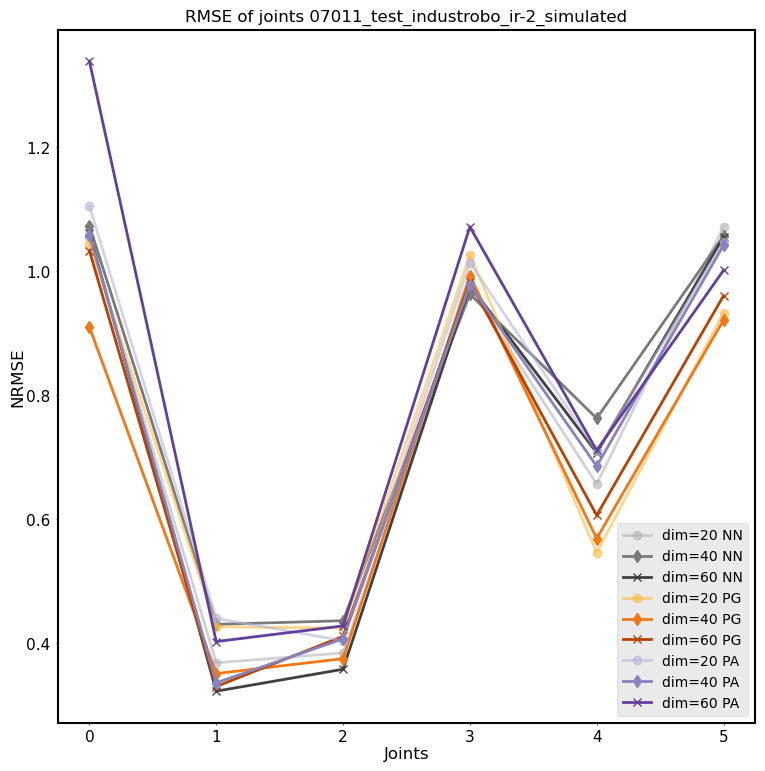

In [17]:
multidim_9(rmse_dim_1_pa, rmse_dim_2_pa, rmse_dim_3_pa, rmse_dim_1_nn, rmse_dim_2_nn, rmse_dim_3_nn, rmse_dim_1_pg, rmse_dim_2_pg, rmse_dim_3_pg, log_name)

### 07011_test_industrobo_ir-2_dsam_simulated_puma

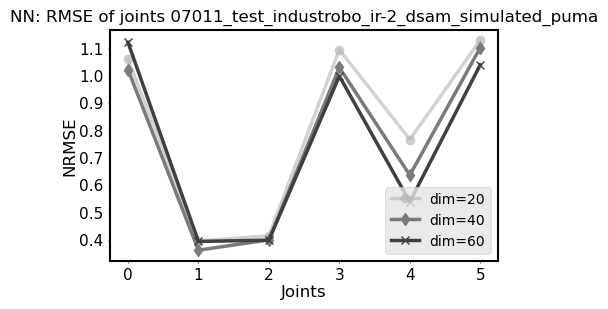

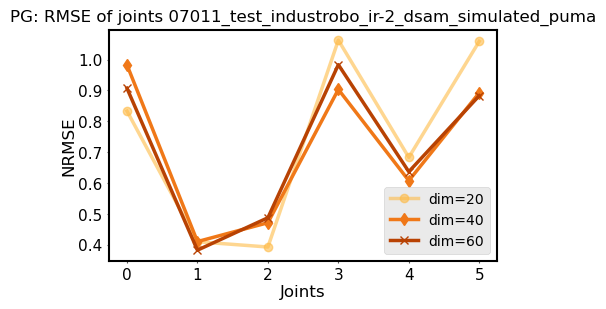

0    1.030187
1    0.472065
2    0.502414
3    1.049335
4    0.858361
5    1.072704
Name: nrmse, dtype: float64


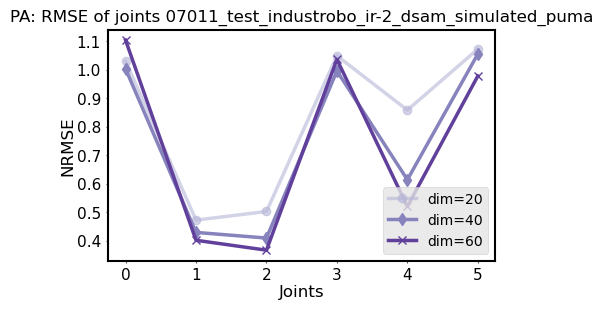

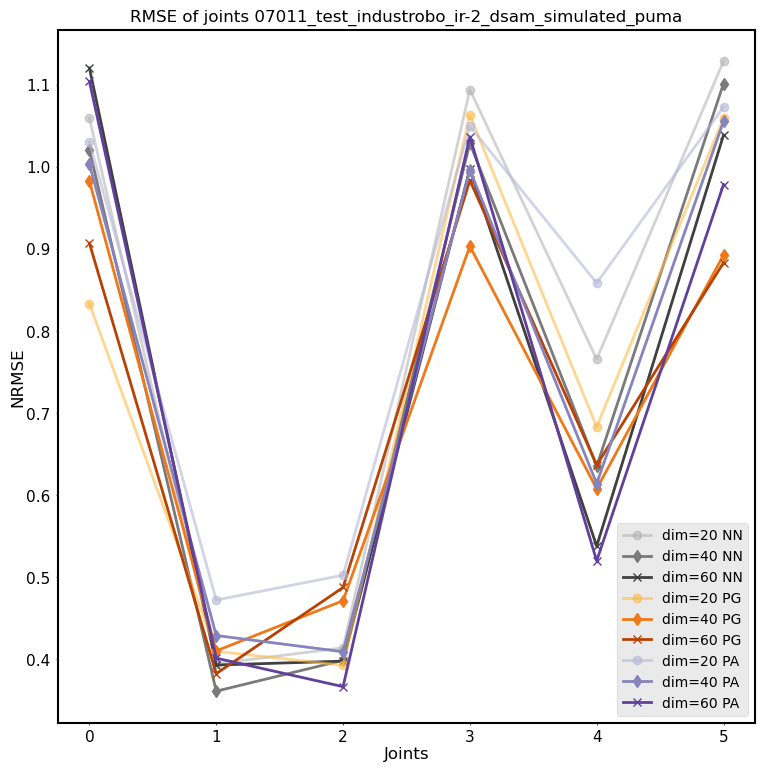

In [3]:
# physics-augment

log_name = "07011_test_industrobo_ir-2_dsam_simulated_puma"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim1 = "20"
h_dim2 = "40"
h_dim3 = "60"


dim_1_path_nn = path.format(log_name,h_dim1,"-10")
dim_2_path_nn = path.format(log_name,h_dim2,"-10")
dim_3_path_nn = path.format(log_name,h_dim3,"-10")

rmse_dim_1_nn=read_nrsme_file(dim_1_path_nn)
rmse_dim_2_nn=read_nrsme_file(dim_2_path_nn)
rmse_dim_3_nn=read_nrsme_file(dim_3_path_nn)
multidim_nn(rmse_dim_1_nn, rmse_dim_2_nn, rmse_dim_3_nn, log_name)

# physics-augment


dim_1_path_pg = path.format(log_name,h_dim1,"100")
dim_2_path_pg = path.format(log_name,h_dim2,"100")
dim_3_path_pg = path.format(log_name,h_dim3,"100")

rmse_dim_1_pg=read_nrsme_file(dim_1_path_pg)
rmse_dim_2_pg=read_nrsme_file(dim_2_path_pg)
rmse_dim_3_pg=read_nrsme_file(dim_3_path_pg)



multidim_pg(rmse_dim_1_pg, rmse_dim_2_pg, rmse_dim_3_pg, log_name)

# physics-augment

dim_1_path_pa = path.format(log_name,h_dim1,"-100")
dim_2_path_pa = path.format(log_name,h_dim2,"-100")
dim_3_path_pa = path.format(log_name,h_dim3,"-100")

rmse_dim_1_pa=read_nrsme_file(dim_1_path_pa)
rmse_dim_2_pa=read_nrsme_file(dim_2_path_pa)
rmse_dim_3_pa=read_nrsme_file(dim_3_path_pa)

multidim_pa(rmse_dim_1_pa, rmse_dim_2_pa, rmse_dim_3_pa, log_name)

multidim_9(rmse_dim_1_pa, rmse_dim_2_pa, rmse_dim_3_pa, rmse_dim_1_nn, rmse_dim_2_nn, rmse_dim_3_nn, rmse_dim_1_pg, rmse_dim_2_pg, rmse_dim_3_pg, log_name)

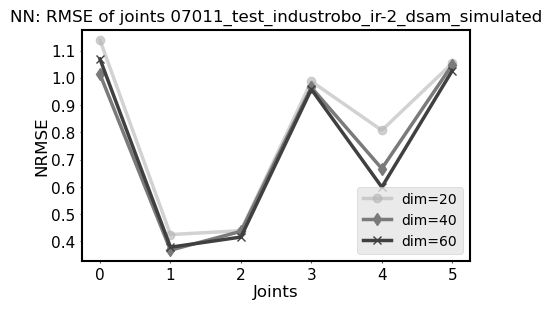

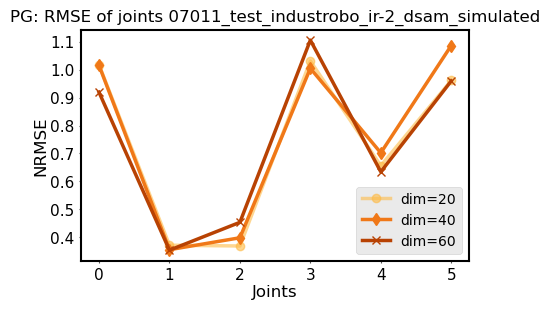

0    1.060212
1    0.498456
2    0.464801
3    1.087669
4    0.685612
5    1.112487
Name: nrmse, dtype: float64


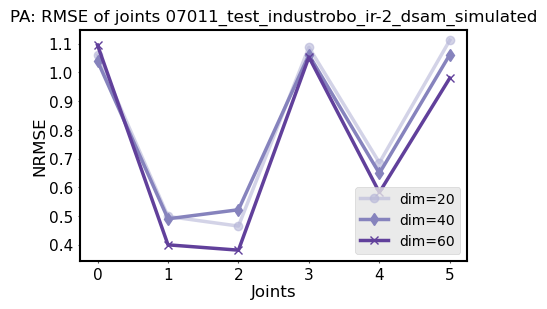

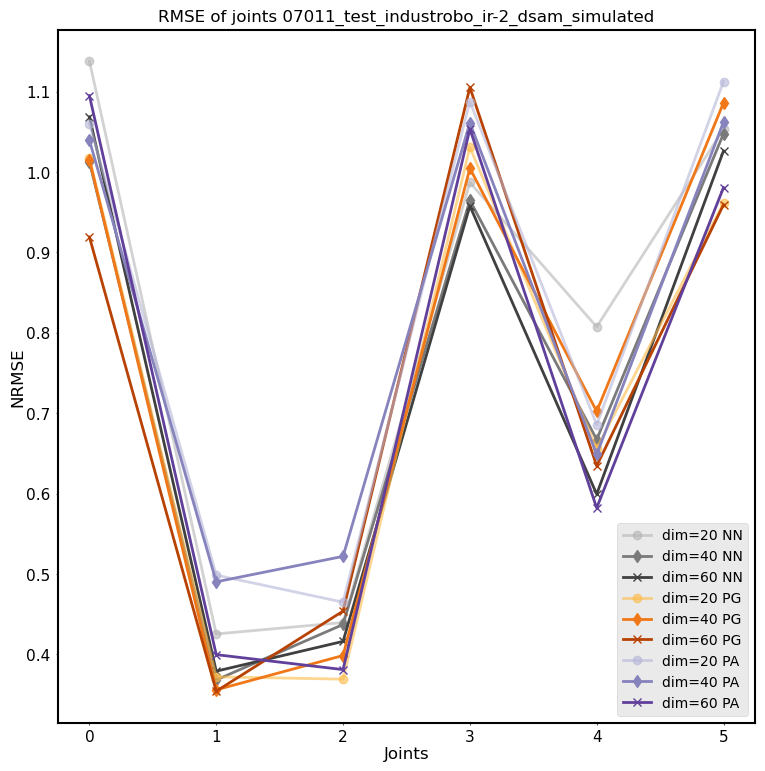

In [4]:
# physics-augment

log_name = "07011_test_industrobo_ir-2_dsam_simulated"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
h_dim1 = "20"
h_dim2 = "40"
h_dim3 = "60"


dim_1_path_nn = path.format(log_name,h_dim1,"-10")
dim_2_path_nn = path.format(log_name,h_dim2,"-10")
dim_3_path_nn = path.format(log_name,h_dim3,"-10")

rmse_dim_1_nn=read_nrsme_file(dim_1_path_nn)
rmse_dim_2_nn=read_nrsme_file(dim_2_path_nn)
rmse_dim_3_nn=read_nrsme_file(dim_3_path_nn)
multidim_nn(rmse_dim_1_nn, rmse_dim_2_nn, rmse_dim_3_nn, log_name)

# physics-augment


dim_1_path_pg = path.format(log_name,h_dim1,"100")
dim_2_path_pg = path.format(log_name,h_dim2,"100")
dim_3_path_pg = path.format(log_name,h_dim3,"100")

rmse_dim_1_pg=read_nrsme_file(dim_1_path_pg)
rmse_dim_2_pg=read_nrsme_file(dim_2_path_pg)
rmse_dim_3_pg=read_nrsme_file(dim_3_path_pg)



multidim_pg(rmse_dim_1_pg, rmse_dim_2_pg, rmse_dim_3_pg, log_name)

# physics-augment

dim_1_path_pa = path.format(log_name,h_dim1,"-100")
dim_2_path_pa = path.format(log_name,h_dim2,"-100")
dim_3_path_pa = path.format(log_name,h_dim3,"-100")

rmse_dim_1_pa=read_nrsme_file(dim_1_path_pa)
rmse_dim_2_pa=read_nrsme_file(dim_2_path_pa)
rmse_dim_3_pa=read_nrsme_file(dim_3_path_pa)

multidim_pa(rmse_dim_1_pa, rmse_dim_2_pa, rmse_dim_3_pa, log_name)

multidim_9(rmse_dim_1_pa, rmse_dim_2_pa, rmse_dim_3_pa, rmse_dim_1_nn, rmse_dim_2_nn, rmse_dim_3_nn, rmse_dim_1_pg, rmse_dim_2_pg, rmse_dim_3_pg, log_name)

### multiple plots for one log_dir

In [6]:



def multiple_plots(path,log_name):
    # Generating sample data
    # log_name = "07011_test_industrobo_ir-2_dsam_simulated"
    # path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
    
    h_dim1 = "20"
    h_dim2 = "40"
    h_dim3 = "60"


    dim_1_path_nn = path.format(log_name,h_dim1,"-10")
    dim_2_path_nn = path.format(log_name,h_dim2,"-10")
    dim_3_path_nn = path.format(log_name,h_dim3,"-10")

    rmse_dim_1_nn=read_nrsme_file(dim_1_path_nn)
    rmse_dim_2_nn=read_nrsme_file(dim_2_path_nn)
    rmse_dim_3_nn=read_nrsme_file(dim_3_path_nn)

    # physics-augment


    dim_1_path_pg = path.format(log_name,h_dim1,"100")
    dim_2_path_pg = path.format(log_name,h_dim2,"100")
    dim_3_path_pg = path.format(log_name,h_dim3,"100")

    rmse_dim_1_pg=read_nrsme_file(dim_1_path_pg)
    rmse_dim_2_pg=read_nrsme_file(dim_2_path_pg)
    rmse_dim_3_pg=read_nrsme_file(dim_3_path_pg)


    # physics-augment

    dim_1_path_pa = path.format(log_name,h_dim1,"-100")
    dim_2_path_pa = path.format(log_name,h_dim2,"-100")
    dim_3_path_pa = path.format(log_name,h_dim3,"-100")

    rmse_dim_1_pa=read_nrsme_file(dim_1_path_pa)
    rmse_dim_2_pa=read_nrsme_file(dim_2_path_pa)
    rmse_dim_3_pa=read_nrsme_file(dim_3_path_pa)
    np.random.seed(0)
    methods = ['NN', 'PG', 'PA']
    complexities = ['20', '40', '60']
    joints = [f'Joint {i+1}' for i in range(6)]

    data = []
    source = [ rmse_dim_1_nn, rmse_dim_2_nn, rmse_dim_3_nn, rmse_dim_1_pg, rmse_dim_2_pg, rmse_dim_3_pg, rmse_dim_1_pa, rmse_dim_2_pa, rmse_dim_3_pa]
    i=0
    for method in methods:
        for complexity in complexities:
            j=0
            for joint in joints:
                values = source[i][j]
                j+=1

                data.append([method, complexity, joint, values])
            i=i+1
    df = pd.DataFrame(data, columns=['Method', 'Complexity', 'Joint', 'Value'])
    print(df)
    # Boxplot
    plt.figure(figsize=(12, 6))
    # sns.boxplot(x='Joint', y='Value', hue='Method', col='Complexity', data=df)
    g = sns.catplot(x='Joint', y='Value', hue='Method', col='Complexity',
                data=df, kind='bar', height=5, aspect=1.5, palette='Set2')
    plt.title('Distribution of Joint Data Points by Method and Complexity')
    plt.show()

    # Line plot using facet grid
    g = sns.FacetGrid(df, row='Method', col='Complexity', margin_titles=True)
    g.map(sns.lineplot, 'Joint', 'Value', marker='o')
    g.add_legend()
    plt.show()

    # Scatter plot for individual methods and complexities
    for method in methods:
        for complexity in complexities:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=df[(df['Method'] == method) & (df['Complexity'] == complexity)],
                            x='Joint', y='Value', hue='Joint', palette='tab10')
            plt.title(f'{method} - {complexity}')
            plt.show()
    return df

   Method Complexity    Joint     Value
0      NN         20  Joint 1  1.055081
1      NN         20  Joint 2  0.368318
2      NN         20  Joint 3  0.384170
3      NN         20  Joint 4  0.972929
4      NN         20  Joint 5  0.656633
5      NN         20  Joint 6  1.072015
6      NN         40  Joint 1  1.073852
7      NN         40  Joint 2  0.430358
8      NN         40  Joint 3  0.436224
9      NN         40  Joint 4  0.963248
10     NN         40  Joint 5  0.762736
11     NN         40  Joint 6  1.056854
12     NN         60  Joint 1  1.062319
13     NN         60  Joint 2  0.322543
14     NN         60  Joint 3  0.357895
15     NN         60  Joint 4  0.977522
16     NN         60  Joint 5  0.707190
17     NN         60  Joint 6  1.055044
18     PG         20  Joint 1  1.044687
19     PG         20  Joint 2  0.426272
20     PG         20  Joint 3  0.424460
21     PG         20  Joint 4  1.026485
22     PG         20  Joint 5  0.545877
23     PG         20  Joint 6  0.932990


/home/ruiyuanli/miniconda3/envs/deepsys/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x600 with 0 Axes>

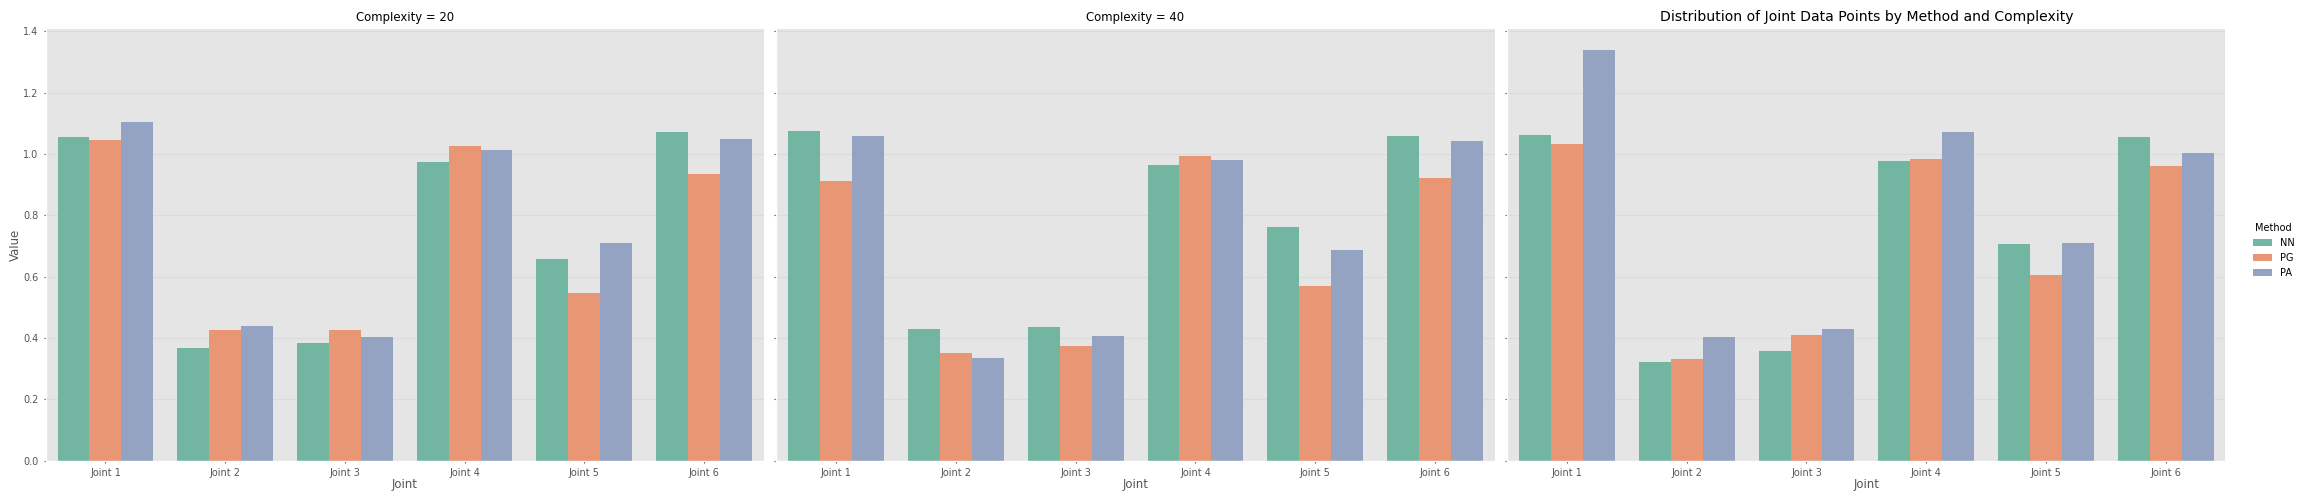

/home/ruiyuanli/miniconda3/envs/deepsys/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


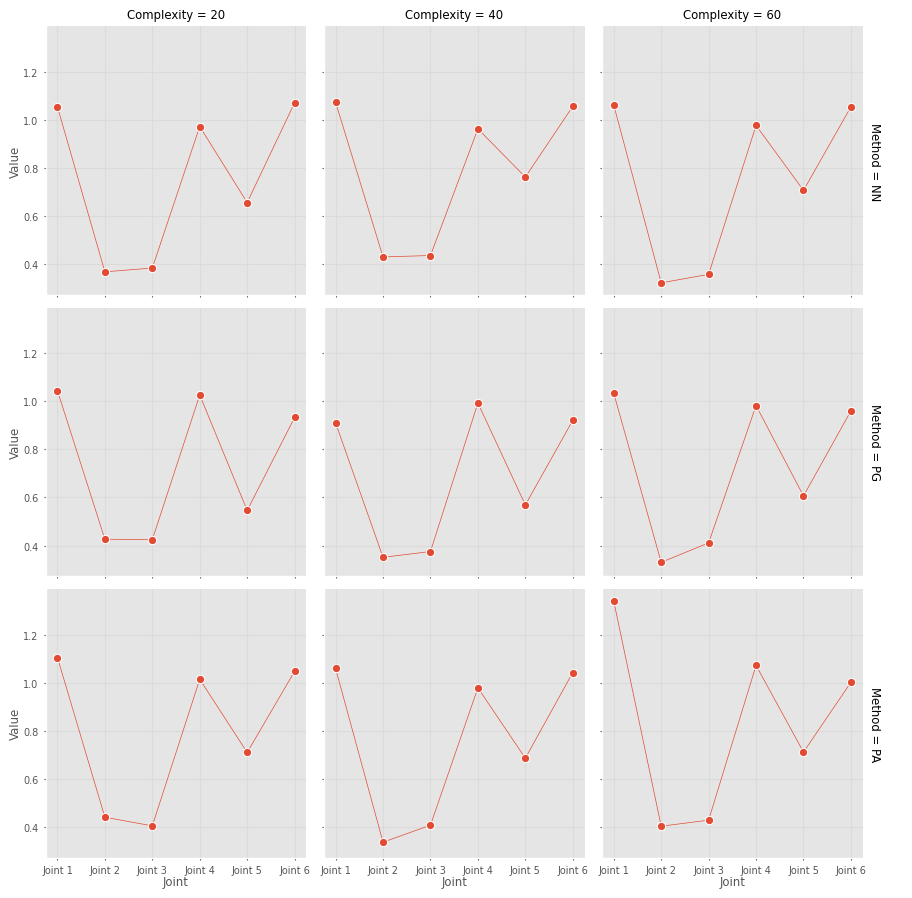

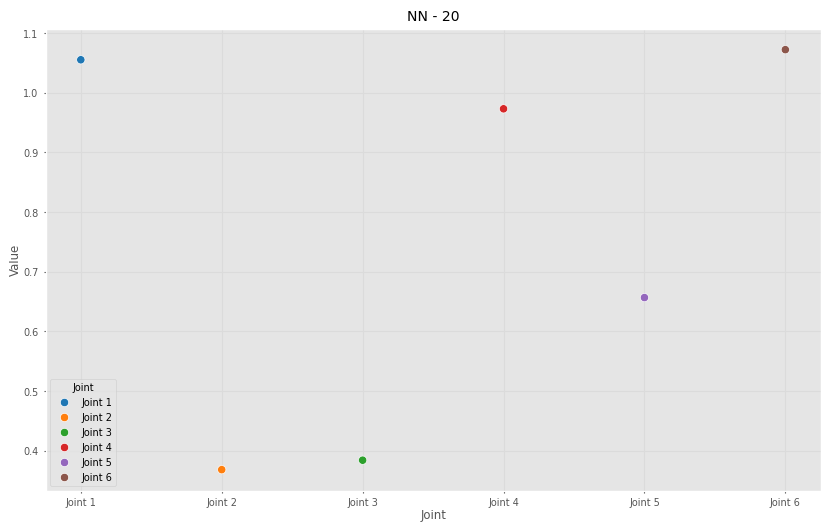

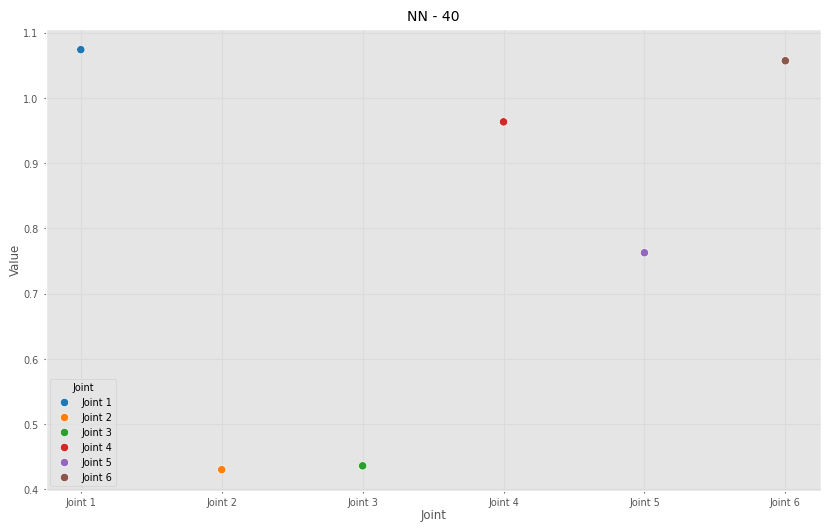

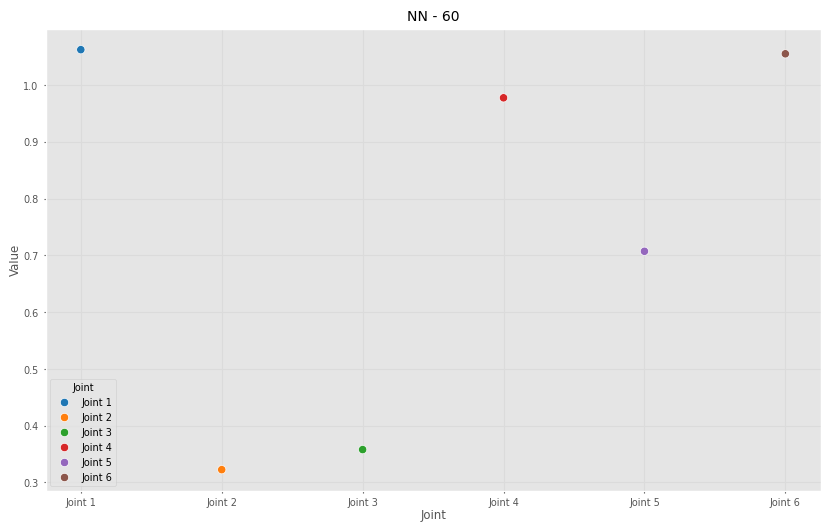

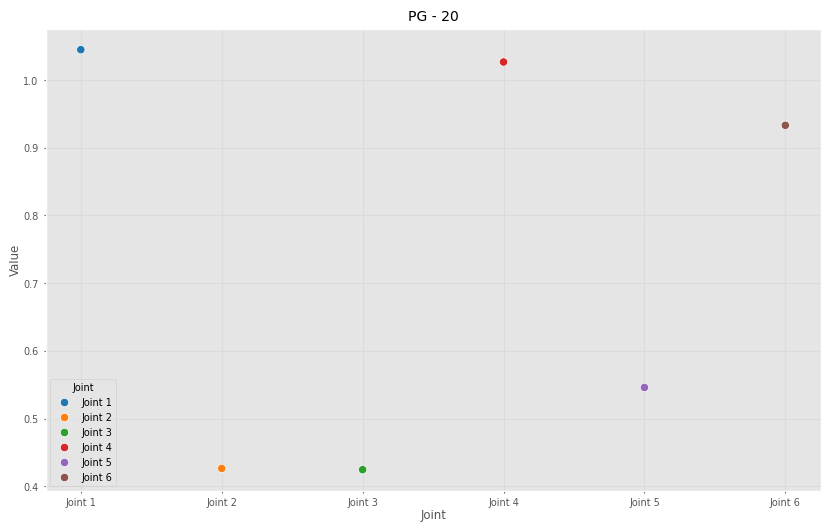

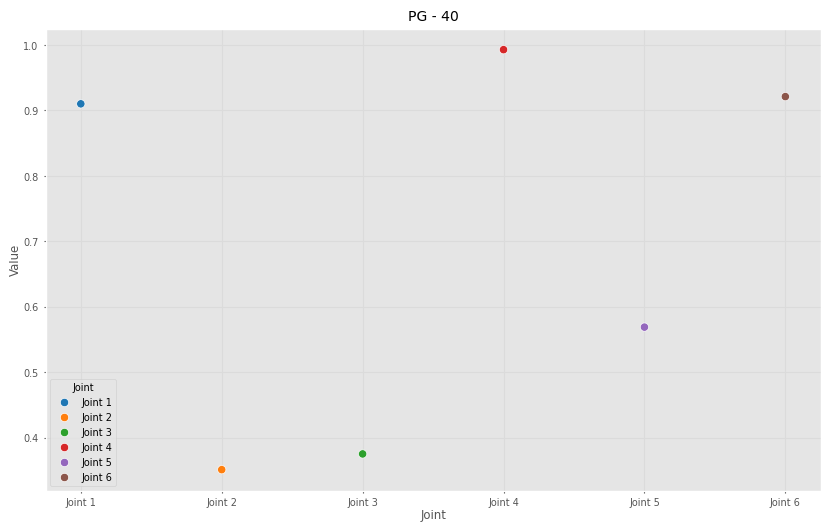

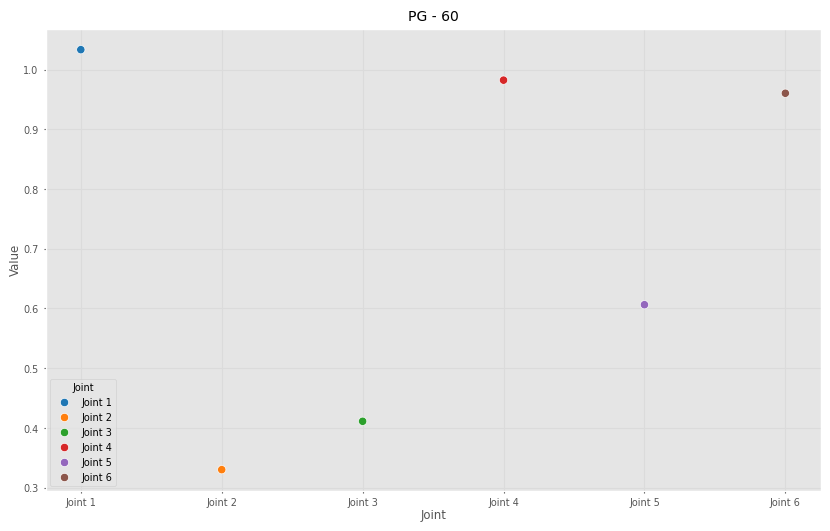

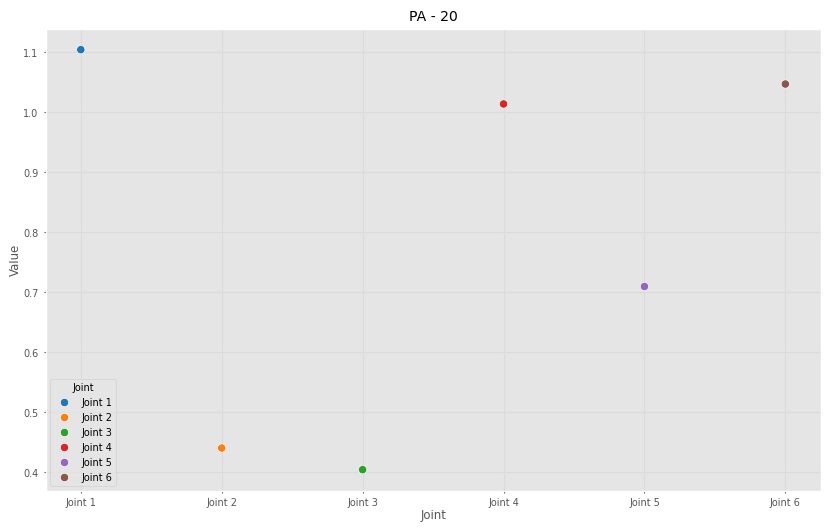

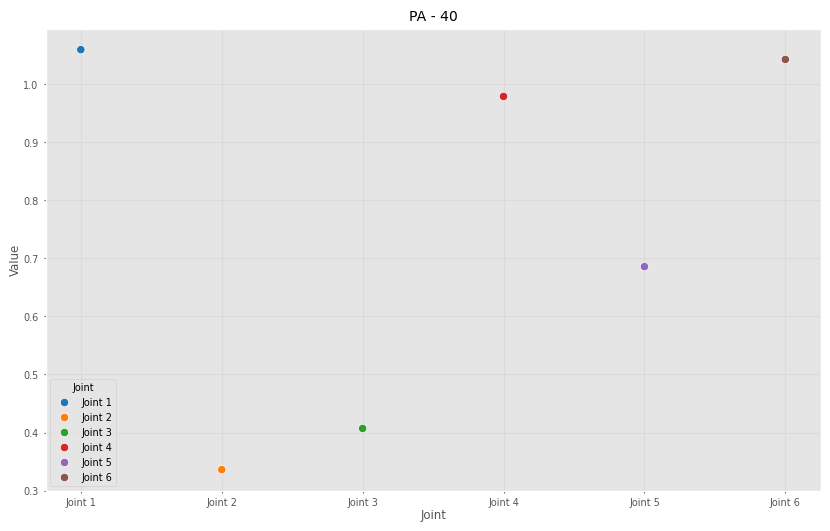

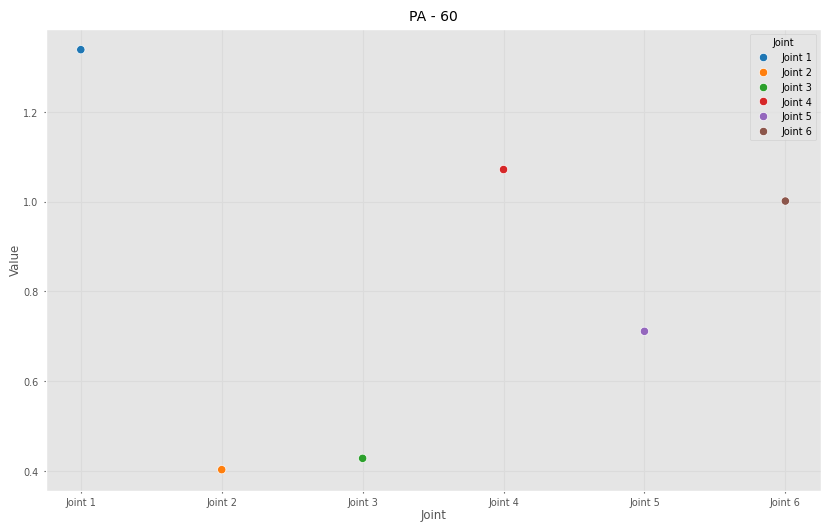

In [38]:
log_name = "07011_test_industrobo_ir-2_simulated"
path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
df = multiple_plots(path,log_name)


In [39]:
df.to_csv('data_simulated.csv',index=False)

## make a large dataframe (configuration+nrmse) 

In [3]:
def nrmse_df(date,config):
    # Generating sample data
    log_name = date+"_test_industrobo_ir-2_"+config
    path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
    
    h_dim1 = "20"
    h_dim2 = "40"
    h_dim3 = "60"


    dim_1_path_nn = path.format(log_name,h_dim1,"-10")
    dim_2_path_nn = path.format(log_name,h_dim2,"-10")
    dim_3_path_nn = path.format(log_name,h_dim3,"-10")

    rmse_dim_1_nn=read_nrsme_file(dim_1_path_nn)
    rmse_dim_2_nn=read_nrsme_file(dim_2_path_nn)
    rmse_dim_3_nn=read_nrsme_file(dim_3_path_nn)
    cc_dim_1_nn=read_cc_file(dim_1_path_nn)
    cc_dim_2_nn=read_cc_file(dim_2_path_nn)
    cc_dim_3_nn=read_cc_file(dim_3_path_nn)
    # physics-augment


    dim_1_path_pa = path.format(log_name,h_dim1,"100")
    dim_2_path_pa = path.format(log_name,h_dim2,"100")
    dim_3_path_pa = path.format(log_name,h_dim3,"100")

    rmse_dim_1_pa=read_nrsme_file(dim_1_path_pa)
    rmse_dim_2_pa=read_nrsme_file(dim_2_path_pa)
    rmse_dim_3_pa=read_nrsme_file(dim_3_path_pa)

    cc_dim_1_pa=read_cc_file(dim_1_path_pa)
    cc_dim_2_pa=read_cc_file(dim_2_path_pa)
    cc_dim_3_pa=read_cc_file(dim_3_path_pa)
    # physics-augment

    dim_1_path_pg = path.format(log_name,h_dim1,"-100")
    dim_2_path_pg = path.format(log_name,h_dim2,"-100")
    dim_3_path_pg = path.format(log_name,h_dim3,"-100")

    rmse_dim_1_pg=read_nrsme_file(dim_1_path_pg)
    rmse_dim_2_pg=read_nrsme_file(dim_2_path_pg)
    rmse_dim_3_pg=read_nrsme_file(dim_3_path_pg)
    cc_dim_1_pg=read_cc_file(dim_1_path_pg)
    cc_dim_2_pg=read_cc_file(dim_2_path_pg)
    cc_dim_3_pg=read_cc_file(dim_3_path_pg)
    np.random.seed(0)
    methods = ['NN', 'PA', 'PG']
    complexities = ['20', '40', '60']
    joints = [f'Joint {i+1}' for i in range(6)]

    data = []
    source_rmse = [ rmse_dim_1_nn, rmse_dim_2_nn, rmse_dim_3_nn,  rmse_dim_1_pa, rmse_dim_2_pa, rmse_dim_3_pa,rmse_dim_1_pg, rmse_dim_2_pg, rmse_dim_3_pg,]
    source_cc = [ cc_dim_1_nn, cc_dim_2_nn, cc_dim_3_nn,cc_dim_1_pa, cc_dim_2_pa, cc_dim_3_pa, cc_dim_1_pg, cc_dim_2_pg, cc_dim_3_pg]
    i=0
    for method in methods:
        for complexity in complexities:
            j=0
            for joint in joints:
                values_rmse = source_rmse[i][j]
                values_cc = source_cc[i][j]
                j+=1

                data.append([method, complexity, joint, values_rmse,values_cc])
            i=i+1
    df = pd.DataFrame(data, columns=['Method', 'Hdim', 'Joint', config+"_nrmse",config+"_cc",])
    # print(df)

    return df



def nrmse_df_multi_nodim(date,config):
    # Generating sample data
    log_name = date+"_test_industrobo_ir-2_"+config
    path = "/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/{}/industrobo/AE-RNN_None/industrobo_h{}_z12_n3_mpw{}_multitrain.csv"
    
    h_dim3 = "60"

    dim_3_path_nn = path.format(log_name,h_dim3,"-10")


    rmse_dim_3_nn=read_nrsme_file(dim_3_path_nn)

    cc_dim_3_nn=read_cc_file(dim_3_path_nn)
    # physics-augment


    dim_3_path_pa = path.format(log_name,h_dim3,"100")


    rmse_dim_3_pa=read_nrsme_file(dim_3_path_pa)


    cc_dim_3_pa=read_cc_file(dim_3_path_pa)
    # physics-augment


    dim_3_path_pg = path.format(log_name,h_dim3,"-100")

    rmse_dim_3_pg=read_nrsme_file(dim_3_path_pg)

    cc_dim_3_pg=read_cc_file(dim_3_path_pg)
    np.random.seed(0)
    methods = ['NN', 'PA', 'PG']
    joints = [f'Joint {i+1}' for i in range(6)]

    data = []
    source_rmse = [  rmse_dim_3_nn,   rmse_dim_3_pa, rmse_dim_3_pg,]
    source_cc = [  cc_dim_3_nn, cc_dim_3_pa, cc_dim_3_pg]
    i=0
    for method in methods:
        j=0
        for joint in joints:
            values_rmse = source_rmse[i][j]
            values_cc = source_cc[i][j]
            j+=1

            data.append([method, joint, values_rmse,values_cc])
        i=i+1
    df = pd.DataFrame(data, columns=['Method', 'Joint', config+"_nrmse",config+"_cc",])
    # print(df)

    return df

# def average_df():
    

In [5]:
dfs=[]

date = "07011"
config = ["dsam_simulated","dsam_simulated_puma","simulated"]
for cf in config:
    df = nrmse_df(date, cf)
    dfs.append(df)
    
date = "07012"
config = ["simulated_noG","simulated_puma"]
# config = ["simulated_puma"]

for cf in config:
    df = nrmse_df(date, cf)
    dfs.append(df)


date = "07018"
config = ["newsimulated","newsimulated_rad"]
# config = ["simulated_puma"]

for cf in config:
    df = nrmse_df(date, cf)
    dfs.append(df)

from functools import reduce
# Merge all DataFrames in the list on ['col1', 'col2']
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['Method', 'Hdim', 'Joint'], how='inner'), dfs)

# merged_df.to_csv('merged_df.csv',index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ruiyuanli/dcscgpuserver1/DeepSSM_SysID/log/07018_test_industrobo_ir-2_newsimulated_rad/industrobo/AE-RNN_None/industrobo_h20_z12_n3_mpw-10_multitrain.csv'

In [ ]:
([Newsimulated Rad 0 Cc]+[Newsimulated Rad 1 Cc]+[Newsimulated Rad 2 Cc]+[Newsimulated Rad 3 Cc]+[Newsimulated Rad 4 Cc])/5
    

In [8]:
dfs_average=[]

# date = "07011"
# config = ["dsam_simulated","dsam_simulated_puma","simulated"]
# for cf in config:
#     df = nrmse_df(date, cf)
#     dfs.append(df)
    
# date = "07012"
# config = ["simulated_noG","simulated_puma"]
# # config = ["simulated_puma"]

# for cf in config:
#     df = nrmse_df(date, cf)
#     dfs.append(df)

dfs_average=[]

date = "07018"
config = []
for i in range(5):
    config.append("newsimulated_rad_dsam_"+str(i))
    
for i in range(5):
    config.append("newsimulated_rad_"+str(i))

for i in range(5):
    config.append("newsimulated_rad_dsam_noG_"+str(i))
    
for i in range(5):
    config.append("newsimulated_rad_dsam_puma_noG_"+str(i))
    
for i in range(5):
    config.append("newsimulated_rad_dsam_puma_"+str(i))
    
for i in range(5):
    config.append("newsimulated_rad_puma_"+str(i))
    
for cf in config:
    df = nrmse_df_multi_nodim(date, cf)
    dfs_average.append(df)

from functools import reduce
# Merge all DataFrames in the list on ['col1', 'col2']
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['Method', 'Joint'], how='inner'), dfs_average)
merged_df.head(5)
# merged_df.to_csv('merged_df_newsim_multi.csv',index=False)
keywords_df = merged_df[['Method','Joint']]
keywords_df.head(2)
keywords_df
method_list = ["newsimulated_rad_dsam_","newsimulated_rad_","newsimulated_rad_dsam_puma_noG_","newsimulated_rad_dsam_puma_","newsimulated_rad_puma_","newsimulated_rad_dsam_noG_"]
for method_name in method_list:
    config = []
    for i in range(5):
        config.append(method_name+str(i)+"_cc")
        config.append(method_name+str(i)+"_nrmse")
        
    
    temp_df = merged_df.loc[:,[i in config for i in merged_df.keys()]]
    print(temp_df.head(5))
    keywords_df[method_name+"cc"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].mean(axis=1)
    keywords_df[method_name+"nrmse"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].mean(axis=1)


   newsimulated_rad_dsam_0_nrmse  newsimulated_rad_dsam_0_cc  \
0                       1.164453                    0.140701   
1                       0.454077                    0.898832   
2                       0.452545                    0.892609   
3                       0.984404                    0.544975   
4                       0.698365                    0.762148   

   newsimulated_rad_dsam_1_nrmse  newsimulated_rad_dsam_1_cc  \
0                       1.015458                    0.050954   
1                       0.433522                    0.903179   
2                       0.441350                    0.901668   
3                       0.956661                    0.524588   
4                       0.800974                    0.708331   

   newsimulated_rad_dsam_2_nrmse  newsimulated_rad_dsam_2_cc  \
0                       1.101681                    0.218608   
1                       0.479361                    0.890061   
2                       0.458019      

/tmp/ipykernel_2824020/3929913632.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_df[method_name+"cc"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].mean(axis=1)
/tmp/ipykernel_2824020/3929913632.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_df[method_name+"nrmse"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].mean(axis=1)
/tmp/ipykernel_2824020/3929913632.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [8]:


dfs_average=[]

# date = "07011"
# config = ["dsam_simulated","dsam_simulated_puma","simulated"]
# for cf in config:
#     df = nrmse_df(date, cf)
#     dfs.append(df)
    
# date = "07012"
# config = ["simulated_noG","simulated_puma"]
# # config = ["simulated_puma"]

# for cf in config:
#     df = nrmse_df(date, cf)
#     dfs.append(df)


date = "07030"
length = ['5','10','25','50']
config = []
for j in range(len(length)):
    for i in range(5):
        config.append("newsimulated_rad_dsam_Len{}pc_".format(length[j])+str(i))
    
    
for cf in config:
    df = nrmse_df_multi_nodim(date, cf)
    dfs_average.append(df)


date = "07018"
config = []
for i in range(5):
    config.append("newsimulated_rad_dsam_"+str(i))
for cf in config:
    df = nrmse_df_multi_nodim(date, cf)
    dfs_average.append(df)
    
from functools import reduce
# Merge all DataFrames in the list on ['col1', 'col2']
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['Method', 'Joint'], how='inner'), dfs_average)
merged_df.head(5)
# merged_df.to_csv('merged_df_newsim_multi.csv',index=False)
keywords_df = merged_df[['Method','Joint']]
keywords_df.head(2)
keywords_df
method_list = ["len5", "len10","len25","len50","len100"]
title_list  = ["newsimulated_rad_dsam_Len5pc_","newsimulated_rad_dsam_Len10pc_","newsimulated_rad_dsam_Len25pc_","newsimulated_rad_dsam_Len50pc_","newsimulated_rad_dsam_"]
for index in range(len(method_list)):
    config = []
    for i in range(5):
        config.append(title_list[index]+str(i)+"_cc")
        config.append(title_list[index]+str(i)+"_nrmse")
        
    
    temp_df = merged_df.loc[:,[i in config for i in merged_df.keys()]]
    print(temp_df.head(5))
    keywords_df[method_list[index]+"_cc"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].mean(axis=1)
    keywords_df[method_list[index]+"_nrmse"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].mean(axis=1)

keywords_df.to_csv('argOnly_ccnrmse_len.csv',index=False)


   newsimulated_rad_dsam_Len5pc_0_nrmse  newsimulated_rad_dsam_Len5pc_0_cc  \
0                              1.084981                           0.023110   
1                              0.601368                           0.828141   
2                              0.567019                           0.827973   
3                              1.086316                           0.346334   
4                              0.987255                           0.547318   

   newsimulated_rad_dsam_Len5pc_1_nrmse  newsimulated_rad_dsam_Len5pc_1_cc  \
0                              1.084981                           0.023110   
1                              0.601368                           0.828141   
2                              0.567019                           0.827973   
3                              1.086316                           0.346334   
4                              0.987255                           0.547318   

   newsimulated_rad_dsam_Len5pc_2_nrmse  newsimulated_rad_dsam

/tmp/ipykernel_3047965/4090391973.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_df[method_list[index]+"_cc"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].mean(axis=1)
/tmp/ipykernel_3047965/4090391973.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_df[method_list[index]+"_nrmse"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].mean(axis=1)
/tmp/ipykernel_3047965/4090391973.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [9]:
keywords_df


Method    Joint   len5_cc  len5_nrmse  len10_cc  len10_nrmse  len25_cc  \
0      NN  Joint 1  0.020833    1.070775 -0.078189     1.090975  0.039067   
1      NN  Joint 2  0.822659    0.594360  0.800596     0.603951  0.887547   
2      NN  Joint 3  0.832547    0.562934  0.879642     0.505513  0.871058   
3      NN  Joint 4  0.331017    1.065231  0.265798     1.077341  0.250845   
4      NN  Joint 5  0.531604    0.984818  0.325406     1.076623  0.691668   
5      NN  Joint 6  0.475321    0.914941  0.428406     0.927819  0.605899   
6      PA  Joint 1  0.692981    0.732266  0.647587     0.796036  0.804823   
7      PA  Joint 2  0.816828    0.587260  0.874263     0.495951  0.864993   
8      PA  Joint 3  0.832768    0.568368  0.865530     0.507547  0.870988   
9      PA  Joint 4  0.492784    0.928283  0.597600     0.853712  0.602540   
10     PA  Joint 5  0.636932    0.859931  0.635547     0.826053  0.745052   
11     PA  Joint 6  0.663315    0.815961  0.659423     0.823185  0.697833   
12     PG  Joint 1  0.116720    1.158469  0.060685     1.187954  0.479361   
13     PG  Joint 2  0.829092    0.594157  0.879400     0.489399  0.876246   
14     PG  Joint 3  0.781764    0.641588  0.871097     0.491717  0.871033   
15     PG  Joint 4  0.229113    1.255785  0.550589     0.926408  0.572491   
16     PG  Joint 5  0.746880    0.793845  0.750061     0.741072  0.731954   
17     PG  Joint 6  0.512535    0.956459  0.499856     0.938888  0.661539   

    len25_nrmse  len50_cc  len50_nrmse  len100_cc  len100_nrmse  
0      1.239507 -0.193521     1.053432   0.147344      1.123901  
1      0.508726  0.897067     0.445822   0.895578      0.460904  
2      0.504743  0.902261     0.435024   0.894079      0.455146  
3      1.161578  0.085334     1.055763   0.506597      1.042982  
4      0.798218  0.676835     0.796560   0.738010      0.788548  
5      0.901110  0.309418     1.010025   0.652429      0.800792  
6      0.678436  0.782226     0.679219   0.867276      0.544958  
7      0.521188  0.854383     0.526133   0.901988      0.464042  
8      0.506562  0.878622     0.491965   0.904906      0.436899  
9      0.893186  0.683494     0.971750   0.638477      1.055056  
10     0.735629  0.722647     0.822440   0.731718      0.789470  
11     0.840723  0.741298     0.801542   0.766072      0.726956  
12     0.959879  0.384513     1.035971   0.685925      0.775906  
13     0.515686  0.899261     0.448277   0.901648      0.461963  
14     0.534461  0.900824     0.447888   0.908852      0.446223  
15     1.019342  0.516390     1.094306   0.590099      0.993232  
16     0.755510  0.751274     0.778852   0.785100      0.715546  
17     0.834179  0.649311     0.841442   0.661288      0.791336

In [20]:


dfs_average=[]

# date = "07011"
# config = ["dsam_simulated","dsam_simulated_puma","simulated"]
# for cf in config:
#     df = nrmse_df(date, cf)
#     dfs.append(df)
    
# date = "07012"
# config = ["simulated_noG","simulated_puma"]
# # config = ["simulated_puma"]

# for cf in config:
#     df = nrmse_df(date, cf)
#     dfs.append(df)


date = "07030"
length = ['10','25','50']
config = []
for j in range(3):
    for i in range(5):
        config.append("newsimulated_rad_dsam_puma_noG_Len{}pc_".format(length[j])+str(i))
    
    
for cf in config:
    df = nrmse_df_multi_nodim(date, cf)
    dfs_average.append(df)


date = "07018"
config = []
for i in range(5):
    config.append("newsimulated_rad_dsam_puma_noG_"+str(i))
for cf in config:
    df = nrmse_df_multi_nodim(date, cf)
    dfs_average.append(df)
    
from functools import reduce
# Merge all DataFrames in the list on ['col1', 'col2']
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['Method', 'Joint'], how='inner'), dfs_average)
merged_df.head(5)
# merged_df.to_csv('merged_df_newsim_multi.csv',index=False)
keywords_df = merged_df[['Method','Joint']]
keywords_df.head(2)
keywords_df
method_list = ["len10","len25","len50","len100"]
title_list  = ["newsimulated_rad_dsam_puma_noG_Len10pc_","newsimulated_rad_dsam_puma_noG_Len25pc_","newsimulated_rad_dsam_puma_noG_Len50pc_","newsimulated_rad_dsam_puma_noG_"]
for index in range(len(method_list)):
    config = []
    for i in range(5):
        config.append(title_list[index]+str(i)+"_cc")
        config.append(title_list[index]+str(i)+"_nrmse")
        
    
    temp_df = merged_df.loc[:,[i in config for i in merged_df.keys()]]
    print(temp_df.head(5))
    keywords_df[method_list[index]+"_cc"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].mean(axis=1)
    keywords_df[method_list[index]+"_nrmse"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].mean(axis=1)

keywords_df.to_csv('puma_nog_argOnly_ccnrmse_len.csv',index=False)


   newsimulated_rad_dsam_puma_noG_Len10pc_0_nrmse  \
0                                        1.100234   
1                                        0.630589   
2                                        0.504726   
3                                        1.087715   
4                                        1.089780   

   newsimulated_rad_dsam_puma_noG_Len10pc_0_cc  \
0                                    -0.061632   
1                                     0.779968   
2                                     0.872916   
3                                     0.263860   
4                                     0.308975   

   newsimulated_rad_dsam_puma_noG_Len10pc_1_nrmse  \
0                                        1.077587   
1                                        0.563600   
2                                        0.508144   
3                                        1.063249   
4                                        1.052682   

   newsimulated_rad_dsam_puma_noG_Len10pc_1_cc  \
0          

/tmp/ipykernel_2824020/783734730.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_df[method_list[index]+"_cc"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].mean(axis=1)
/tmp/ipykernel_2824020/783734730.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_df[method_list[index]+"_nrmse"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].mean(axis=1)
/tmp/ipykernel_2824020/783734730.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [60]:

keys=[]
for i in range(5):
    keys.append("newsimulated_rad_dsam_"+str(i)+"_cc")
    
merged_df[keys].mean(axis=1)

0     0.147344
1     0.895578
2     0.894079
3     0.506597
4     0.738010
5     0.652429
6     0.867276
7     0.901988
8     0.904906
9     0.638477
10    0.731718
11    0.766072
12    0.685925
13    0.901648
14    0.908852
15    0.590099
16    0.785100
17    0.661288
dtype: float64

In [14]:
keywords_df = merged_df[['Method','Joint']]
keywords_df.head(2)
keywords_df
method_list = ["newsimulated_rad_dsam_","newsimulated_rad_","newsimulated_rad_dsam_puma_noG_","newsimulated_rad_dsam_puma_","newsimulated_rad_puma_","newsimulated_rad_dsam_noG_"]
for method_name in method_list:
    config = []
    for i in range(5):
        config.append(method_name+str(i)+"_cc")
        config.append(method_name+str(i)+"_nrmse")
        
    
    temp_df = merged_df.loc[:,[i in config for i in merged_df.keys()]]
    print(temp_df.head(5))
    keywords_df[method_name+"cc_std"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].std(axis=1)
    keywords_df[method_name+"nrmse_std"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].std(axis=1)
keywords_df.to_csv('stdOnly_ccnrmse.csv',index=False)

   newsimulated_rad_dsam_0_nrmse  newsimulated_rad_dsam_0_cc  \
0                       1.164453                    0.140701   
1                       0.454077                    0.898832   
2                       0.452545                    0.892609   
3                       0.984404                    0.544975   
4                       0.698365                    0.762148   

   newsimulated_rad_dsam_1_nrmse  newsimulated_rad_dsam_1_cc  \
0                       1.015458                    0.050954   
1                       0.433522                    0.903179   
2                       0.441350                    0.901668   
3                       0.956661                    0.524588   
4                       0.800974                    0.708331   

   newsimulated_rad_dsam_2_nrmse  newsimulated_rad_dsam_2_cc  \
0                       1.101681                    0.218608   
1                       0.479361                    0.890061   
2                       0.458019      

/tmp/ipykernel_2824020/3355960131.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_df[method_name+"cc_std"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].std(axis=1)
/tmp/ipykernel_2824020/3355960131.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_df[method_name+"nrmse_std"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].std(axis=1)
/tmp/ipykernel_2824020/3355960131.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

#### the real dataset

In [11]:

dfs_average=[]

date = "07031"
config = []

for i in range(5):
    config.append("rad_dsam_"+str(i))
    
for i in range(5):
    config.append("rad_dsam_puma_noG_"+str(i))
    
for cf in config:
    df = nrmse_df_multi_nodim(date, cf)
    dfs_average.append(df)

from functools import reduce
# Merge all DataFrames in the list on ['col1', 'col2']
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['Method', 'Joint'], how='inner'), dfs_average)
merged_df.head(5)
# merged_df.to_csv('merged_df_newsim_multi.csv',index=False)
keywords_df = merged_df[['Method','Joint']]
keywords_df.head(2)
keywords_df
method_list = ["rad_dsam_","rad_dsam_puma_noG_"]
for method_name in method_list:
    config = []
    for i in range(5):
        config.append(method_name+str(i)+"_cc")
        config.append(method_name+str(i)+"_nrmse")
        
    
    temp_df = merged_df.loc[:,[i in config for i in merged_df.keys()]]
    print(temp_df.head(5))
    keywords_df[method_name+"cc"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].mean(axis=1)
    keywords_df[method_name+"nrmse"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].mean(axis=1)

   rad_dsam_0_nrmse  rad_dsam_0_cc  rad_dsam_1_nrmse  rad_dsam_1_cc  \
0          0.905724       0.564279          0.950607       0.554426   
1          0.777679       0.660777          0.788757       0.693169   
2          0.839338       0.627234          0.823999       0.592990   
3          0.942665       0.405386          1.000630       0.249198   
4          1.046403       0.389521          1.043750       0.264777   

   rad_dsam_2_nrmse  rad_dsam_2_cc  rad_dsam_3_nrmse  rad_dsam_3_cc  \
0          0.934639       0.539034          1.181425       0.502886   
1          0.825380       0.641506          0.846138       0.612883   
2          0.806281       0.624218          0.797369       0.646499   
3          1.011951       0.183165          0.977879       0.262151   
4          1.046752       0.237894          1.081662       0.221509   

   rad_dsam_4_nrmse  rad_dsam_4_cc  
0          0.860907       0.524645  
1          0.793061       0.645145  
2          0.781444       0.632382 

/tmp/ipykernel_3637013/3568950101.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_df[method_name+"cc"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].mean(axis=1)
/tmp/ipykernel_3637013/3568950101.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_df[method_name+"nrmse"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].mean(axis=1)
/tmp/ipykernel_3637013/3568950101.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [12]:
keywords_df.to_csv('argOnly_ccnrmse_real.csv',index=False)


In [39]:
dfs_average = []

date = "07031"
length = ['5','10','25','50']
config = []
for j in range(len(length)):
    for i in range(5):
        config.append("rad_dsam_Len{}pc_".format(length[j])+str(i))
    
    
for cf in config:
    df = nrmse_df_multi_nodim(date, cf)
    dfs_average.append(df)


    
date = "07031"
config = []
for i in range(5):
    config.append("rad_dsam_"+str(i))
for cf in config:
    df = nrmse_df_multi_nodim(date, cf)
    dfs_average.append(df)
    
from functools import reduce
# Merge all DataFrames in the list on ['col1', 'col2']
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['Method', 'Joint'], how='inner'), dfs_average)
print(merged_df.head(2))
print(merged_df["rad_dsam_Len50pc_0_nrmse"])
# merged_df.to_csv('merged_df_newsim_multi.csv',index=False)
keywords_df = merged_df[['Method','Joint']]


method_list = ["len5","len10","len25","len50","len100"]
title_list  = ["rad_dsam_Len5pc_","rad_dsam_Len10pc_","rad_dsam_Len25pc_","rad_dsam_Len50pc_","rad_dsam_"]
for index in range(len(method_list)):
    config = []
    for i in range(5):
        config.append(title_list[index]+str(i)+"_cc")
        config.append(title_list[index]+str(i)+"_nrmse")
        
    
    temp_df = merged_df.loc[:,[i in config for i in merged_df.keys()]]
    print(temp_df.head(5))
    keywords_df[method_list[index]+"_cc"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].mean(axis=1)
    keywords_df[method_list[index]+"_nrmse"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].mean(axis=1)

keywords_df.to_csv('argOnly_ccnrmse_len_real.csv',index=False)


  Method    Joint  rad_dsam_Len5pc_0_nrmse  rad_dsam_Len5pc_0_cc  \
0     NN  Joint 1                 0.999872              0.125224   
1     NN  Joint 2                 0.860370              0.538708   

   rad_dsam_Len5pc_1_nrmse  rad_dsam_Len5pc_1_cc  rad_dsam_Len5pc_2_nrmse  \
0                 0.999872              0.125223                 0.999872   
1                 0.860370              0.538708                 0.860370   

   rad_dsam_Len5pc_2_cc  rad_dsam_Len5pc_3_nrmse  rad_dsam_Len5pc_3_cc  ...  \
0              0.125224                 0.999872              0.125224  ...   
1              0.538708                 0.860370              0.538708  ...   

   rad_dsam_0_nrmse  rad_dsam_0_cc  rad_dsam_1_nrmse  rad_dsam_1_cc  \
0          0.905724       0.564279          0.950607       0.554426   
1          0.777679       0.660777          0.788757       0.693169   

   rad_dsam_2_nrmse  rad_dsam_2_cc  rad_dsam_3_nrmse  rad_dsam_3_cc  \
0          0.934639       0.539034      

/tmp/ipykernel_3637013/3265900392.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_df[method_list[index]+"_cc"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].mean(axis=1)
/tmp/ipykernel_3637013/3265900392.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_df[method_list[index]+"_nrmse"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].mean(axis=1)
/tmp/ipykernel_3637013/3265900392.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [ ]:

dfs_average=[]

date = "07031"
config = []

for i in range(5):
    config.append("rad_dsam_"+str(i))
    
for i in range(5):
    config.append("rad_dsam_puma_noG_"+str(i))
    
for cf in config:
    df = nrmse_df_multi_nodim(date, cf)
    dfs_average.append(df)

from functools import reduce
# Merge all DataFrames in the list on ['col1', 'col2']
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['Method', 'Joint'], how='inner'), dfs_average)
merged_df.head(5)
# merged_df.to_csv('merged_df_newsim_multi.csv',index=False)
keywords_df = merged_df[['Method','Joint']]
keywords_df.head(2)
keywords_df
method_list = ["rad_dsam_","rad_dsam_puma_noG_"]
for method_name in method_list:
    config = []
    for i in range(5):
        config.append(method_name+str(i)+"_cc")
        config.append(method_name+str(i)+"_nrmse")
        
    
    temp_df = merged_df.loc[:,[i in config for i in merged_df.keys()]]
    print(temp_df.head(5))

    keywords_df[method_name+"cc_std"]=temp_df.loc[:,['cc' in i for i in temp_df.keys()]].std(axis=1)
    keywords_df[method_name+"nrmse_std"]=temp_df.loc[:,['nrmse' in i for i in temp_df.keys()]].std(axis=1)
keywords_df.to_csv('stdOnly_ccnrmse_real.csv',index=False)